In [79]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path) 

from importlib import reload  # Python 3.4+
        
import pandas as pd
import numpy as np

from pygents.text import * 
from pygents.plot import * 

r = reload(sys.modules['pygents.plot'])

In [2]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2655800/
# https://lena-voita.github.io/nlp_course/language_modeling.html
# https://en.wikipedia.org/wiki/Perplexity
# https://github.com/singnet/language-learning/issues/255
# https://medium.com/mlearning-ai/word-embeddings-wordpiece-and-language-agnostic-bert-labse-98c7626878c7


In [3]:
feeds_df = pd.read_csv('data/media/crypto_twitter_reddit_20220313.tsv',sep ='\t')
print(len(feeds_df))


161823


In [4]:
feeds_df

,Unnamed: 0,time,type,link,permalink,text
0,0,2021-05-04 11:13:44+00:00,twitter,https://twitter.com/ethhub_io,https://twitter.com/ethhub_io/status/138953872...,RT @sassal0x: The last week in Ethereum: -@Me...
1,1,2021-05-04 18:45:38+00:00,twitter,https://twitter.com/ethhub_io,https://twitter.com/ethhub_io/status/138965245...,RT @econoar: EthHub Weekly #164 -ETH hits $35...
2,2,2021-05-07 23:34:45+00:00,reddit,https://www.reddit.com/r/ethereum/,/r/ethereum/comments/n71ai7/eth_20_and_what_wi...,"Eth 2.0 and ""what will happen to your ETH"" Can..."
3,3,2021-05-11 06:43:32+00:00,twitter,https://twitter.com/ethhub_io,https://twitter.com/ethhub_io/status/139200744...,RT @sassal0x: The last week in Ethereum: -@va...
4,4,2021-05-12 16:11:03+00:00,twitter,https://twitter.com/ethereumJoseph,https://twitter.com/ethereumJoseph/status/1392...,"Layer 2 technology is helping scale #Ethereum,..."
...,...,...,...,...,...,...
161818,161818,2022-03-12 23:00:01+00:00,twitter,https://twitter.com/WeekInEthNews,https://twitter.com/WeekInEthNews/status/15027...,@StarbloomVent @evan_van_ness @showkarma_xyz h...
161819,161819,2022-03-12 23:00:36+00:00,twitter,https://twitter.com/Cointelegraph,https://twitter.com/Cointelegraph/status/15027...,Power to the people. Despite 15% of BItcoin ...
161820,161820,2022-03-12 23:06:05+00:00,twitter,https://twitter.com/tanzeel_akhtar,https://twitter.com/Tanzeel_Akhtar/status/1502...,@zackvoell @fintechfrank @RampCapitalLLC 1 4 D...
161821,161821,2022-03-12 23:20:44+00:00,twitter,https://twitter.com/NeerajKA,https://twitter.com/NeerajKA/status/1502786702...,"@MrHodl throw in a beef braise. or in a stock,..."


In [5]:
max_n = 7 # https://www.sciencedirect.com/science/article/abs/pii/0378375886901692

counter = grams_init(max_n)
#grams_count(counter,list("abc"),2)
text_grams_count(counter,"abcde",max_n)
text_grams_count(counter,"abcfg",max_n)
counter

[{'a': 2, 'b': 2, 'c': 2, 'd': 1, 'e': 1, 'f': 1, 'g': 1},
 {'ab': 2, 'bc': 2, 'cd': 1, 'de': 1, 'cf': 1, 'fg': 1},
 {'abc': 2, 'bcd': 1, 'cde': 1, 'bcf': 1, 'cfg': 1},
 {'abcd': 1, 'bcde': 1, 'abcf': 1, 'bcfg': 1},
 {'abcde': 1, 'abcfg': 1},
 {},
 {}]

In [6]:
counters1 = grams_init(max_n)

for text in feeds_df['text']:
    text = preprocess_text(text)
    text_grams_count(counters1,text,max_n)

dfs = []
for i in range(len(counters1)):
    counter = counters1[i]
    df = pd.DataFrame([(gram, counter[gram]) for gram in counter],columns=['gram','freq'])
    df['log'] = np.log10(df['freq'])
    df.sort_values('freq',ascending=False,inplace=True)
    df.title = str(i)
    dfs.append(df)

/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128071 (\N{WHITE DOWN POINTING BACKHAND INDEX}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151

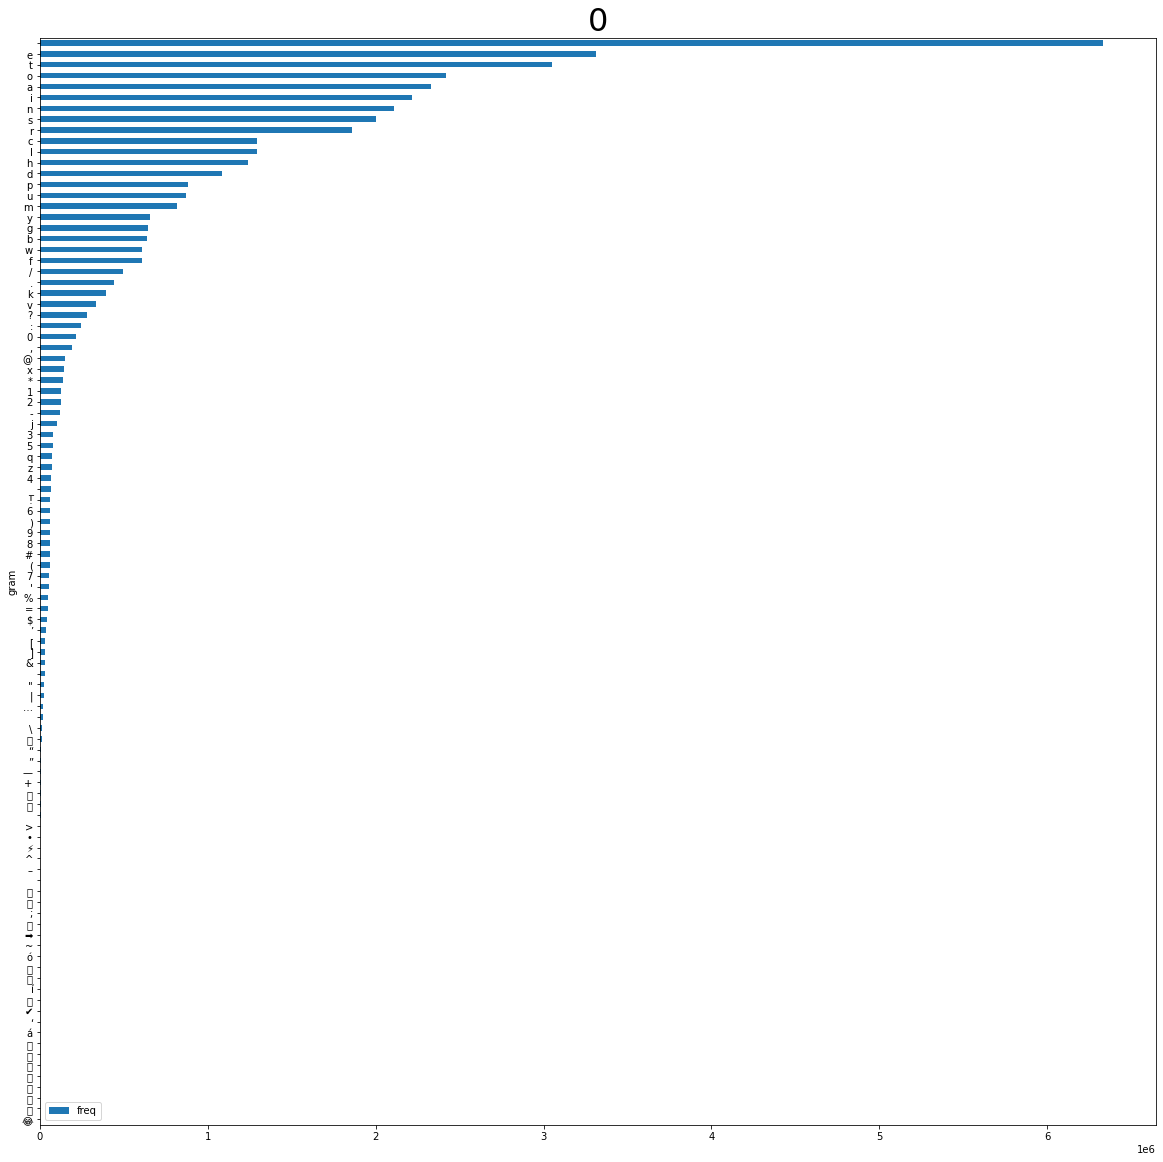

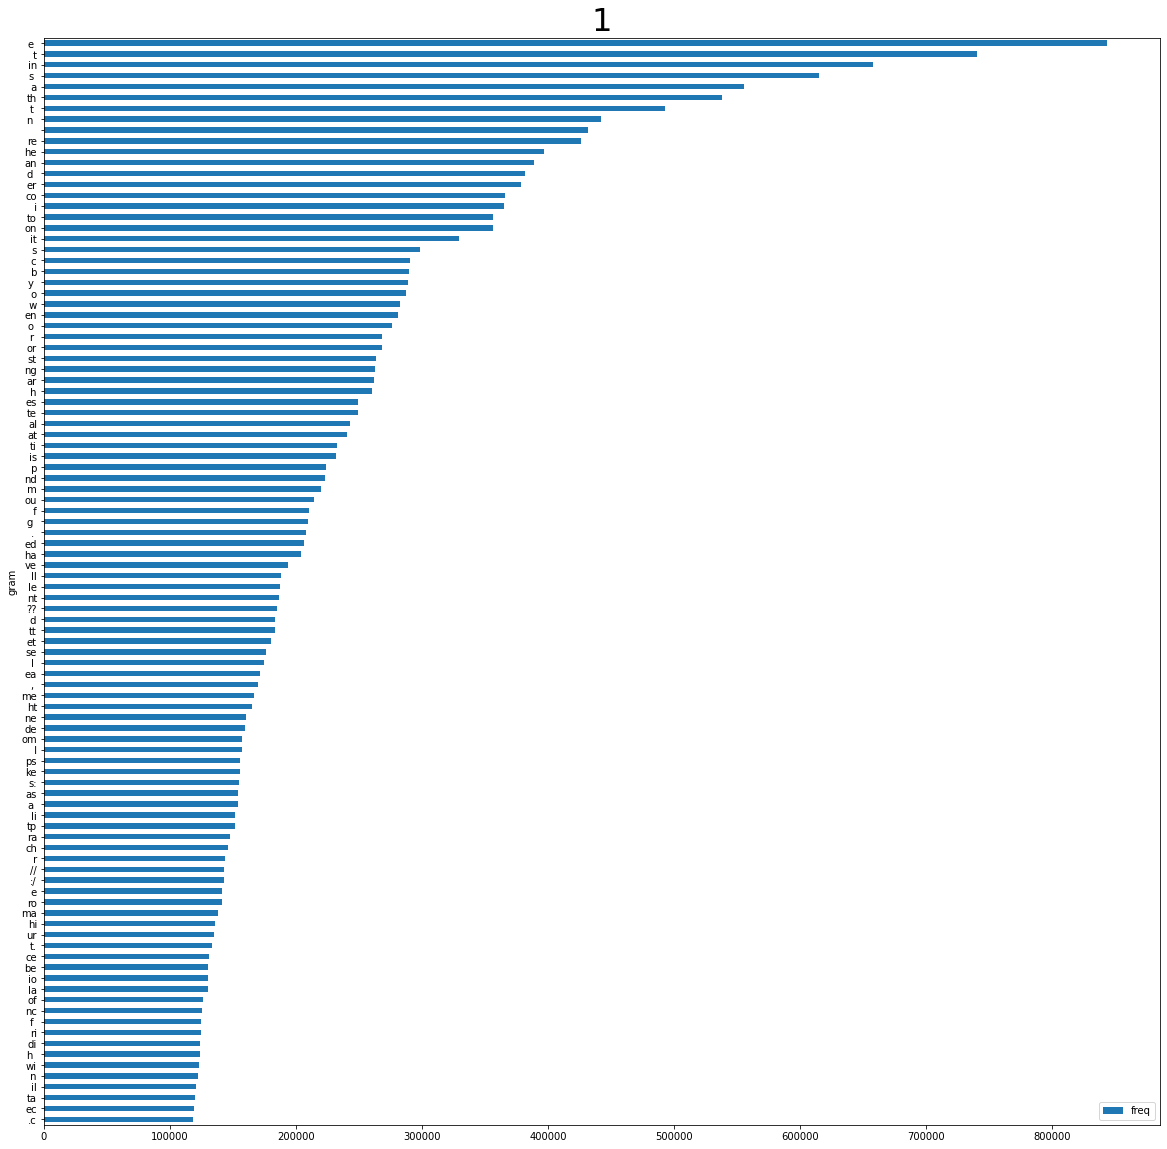

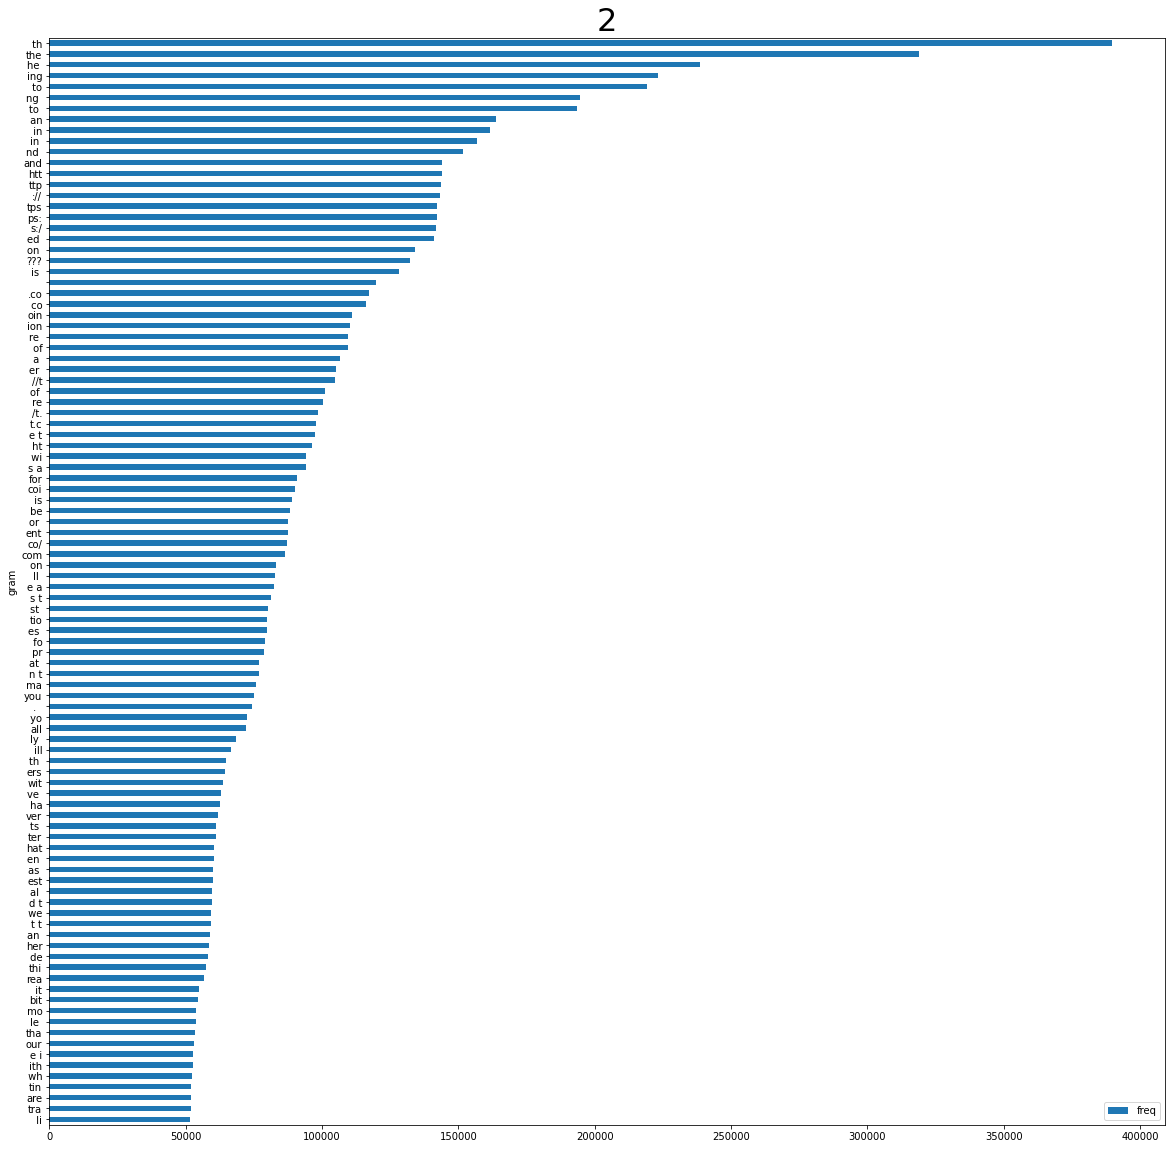

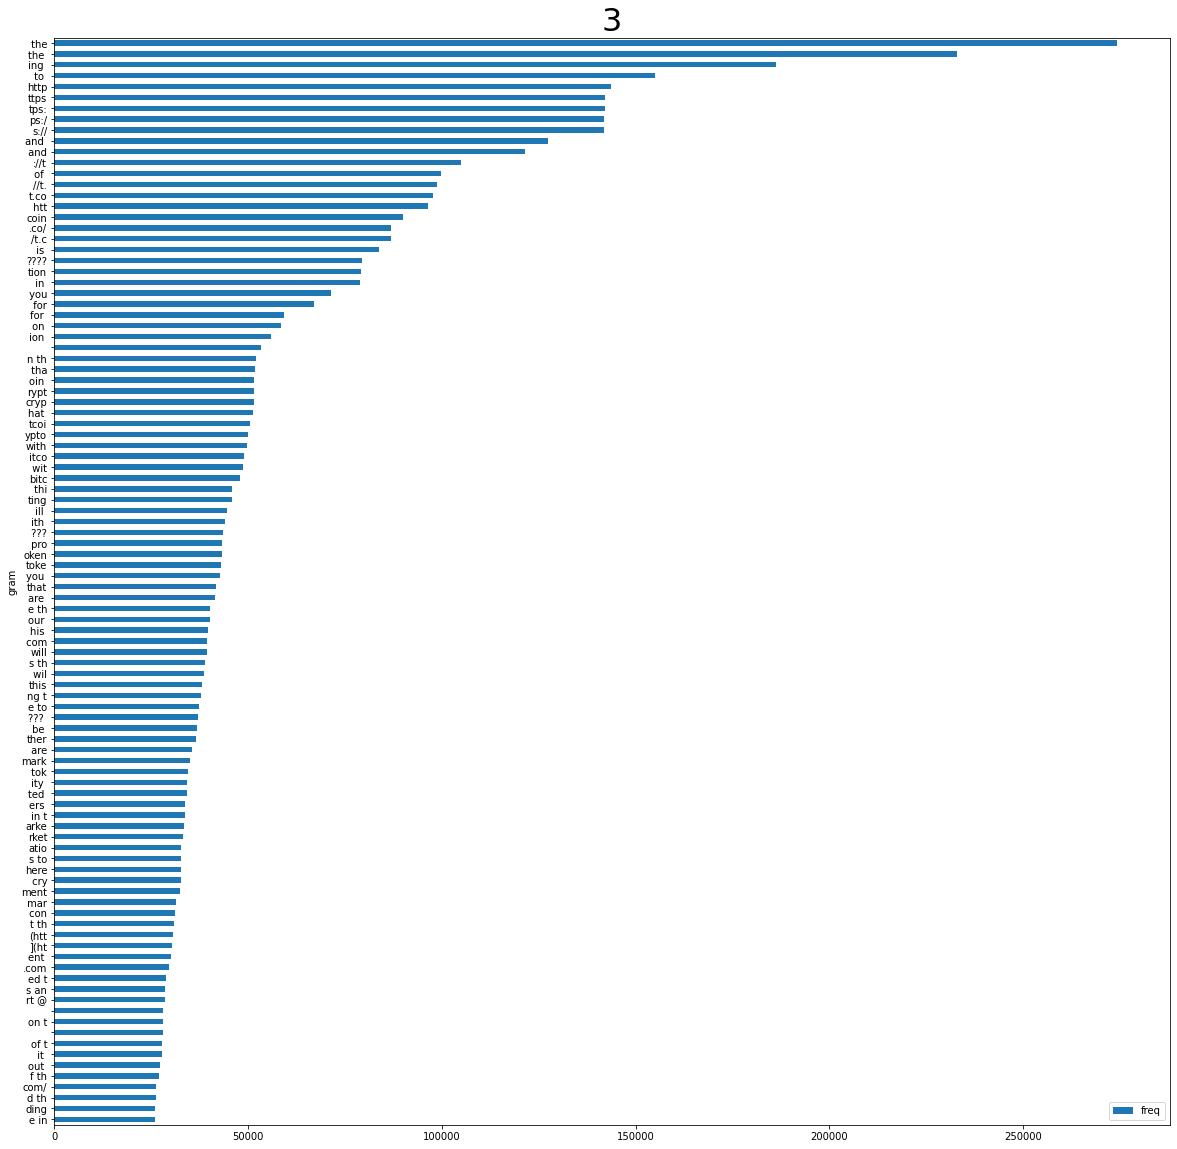

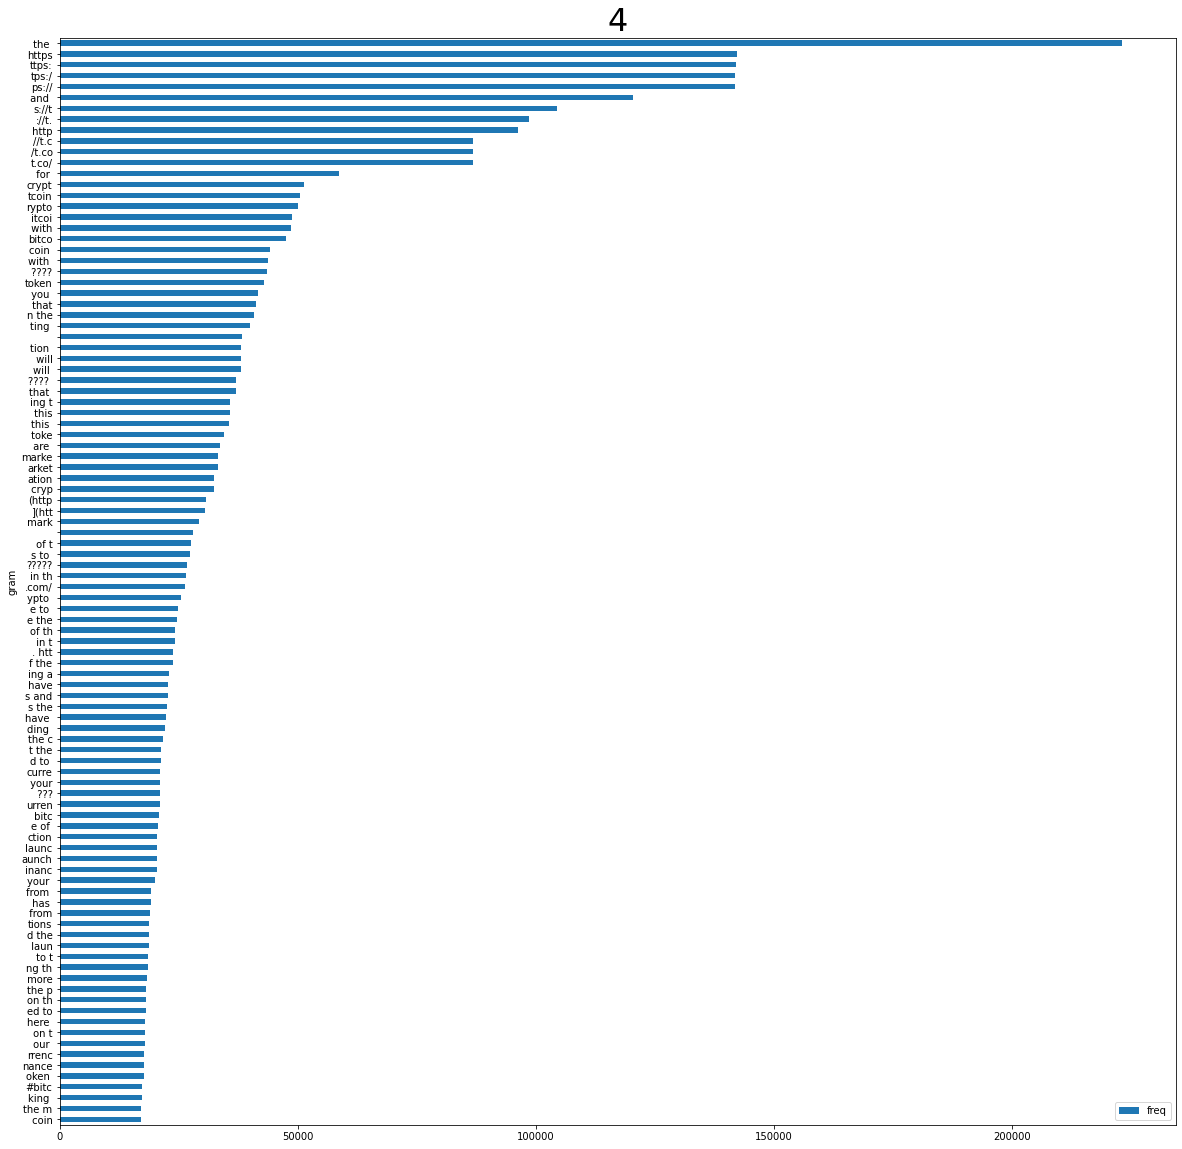

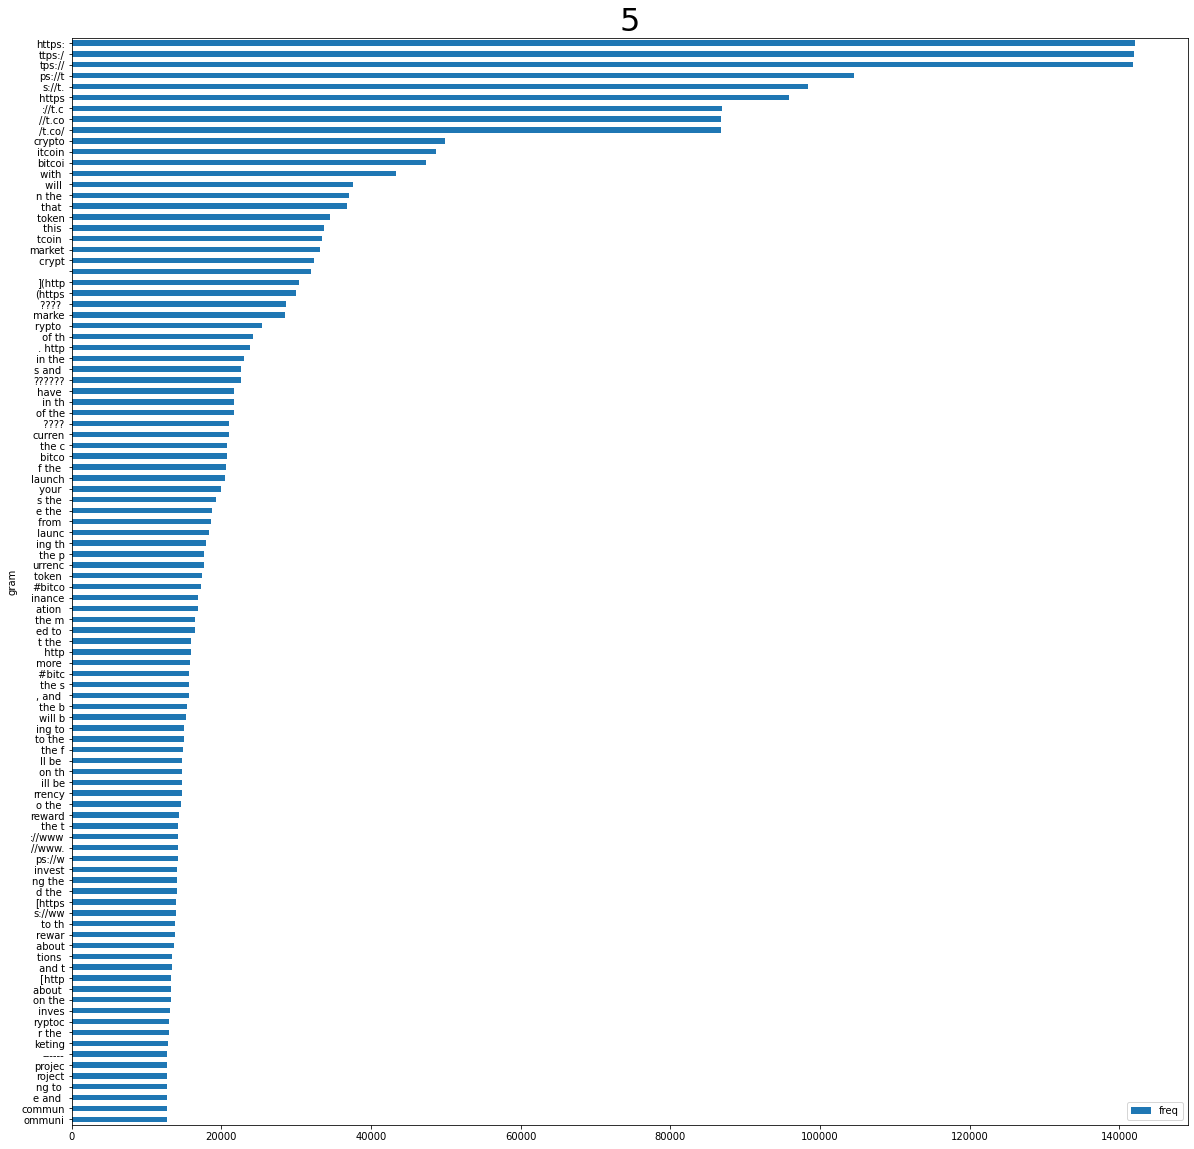

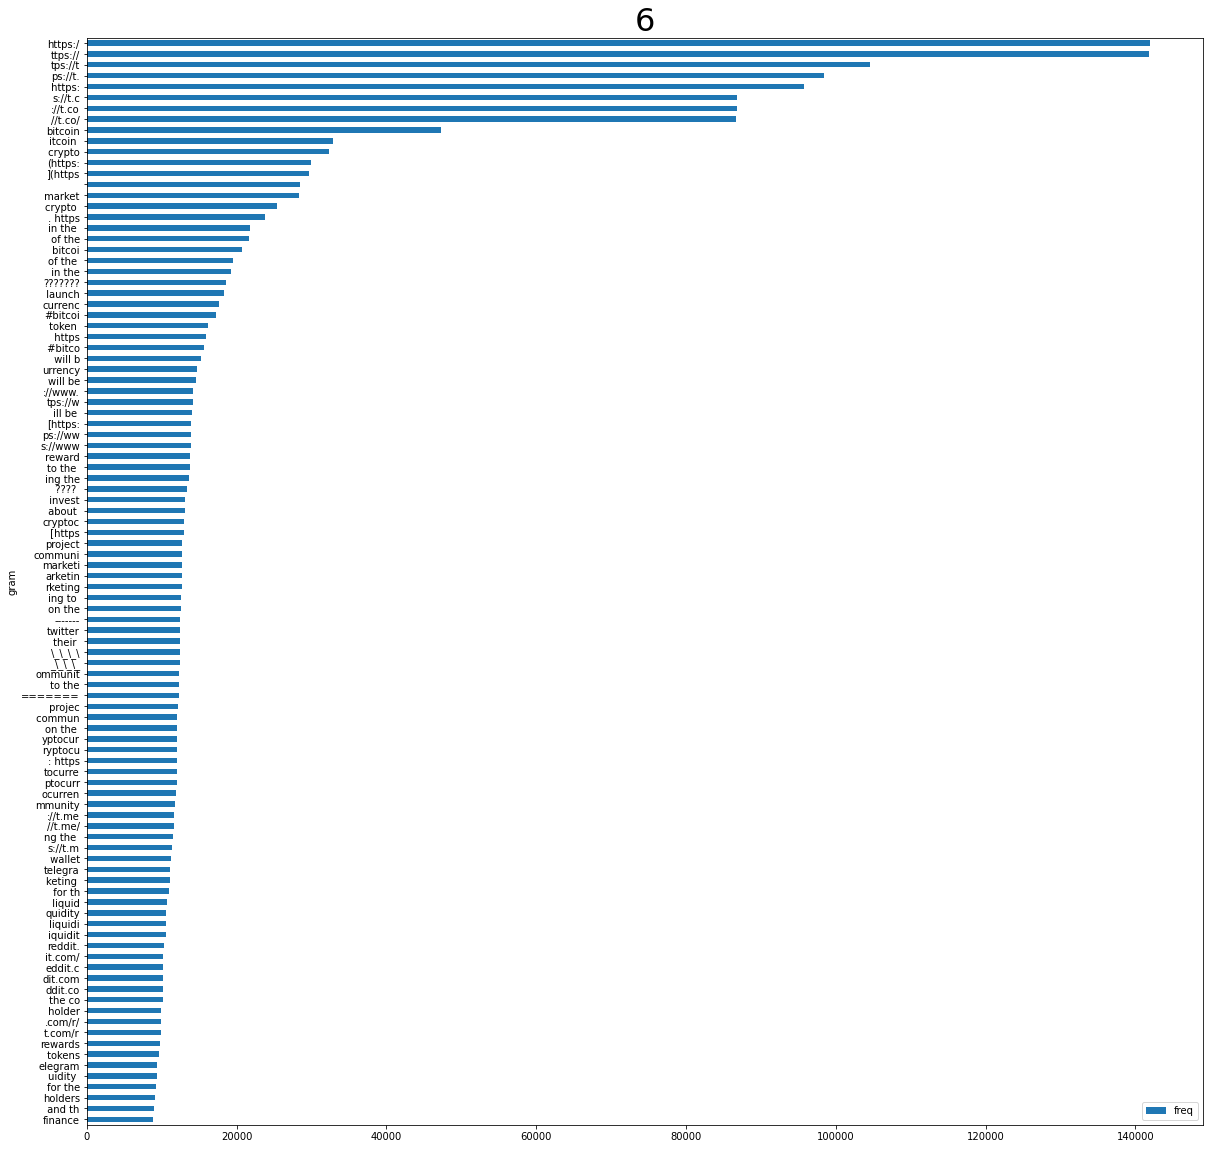

In [7]:
plt.rcParams["figure.figsize"] = (20,20)
for df in dfs:
    p = df[:100][['gram','freq']].plot.barh(x='gram'); p.invert_yaxis();
    p.set_title(df.title,fontsize = 32)
    plt.show()
    

In [8]:
all_counters1 = {}
for counter in counters1:
    all_counters1 = merge_two_dicts(all_counters1,counter)

In [10]:
all_df = pd.DataFrame([(gram, all_counters1[gram]) for gram in all_counters1],columns=['gram','freq'])
all_df['log'] = np.log10(all_df['freq'])
all_df.sort_values('freq',ascending=False,inplace=True)
all_df

,gram,freq,log
2,,6329755,6.801387
11,e,3311340,6.520004
1,t,3050884,6.484426
20,o,2419007,6.383637
5,a,2332210,6.367768
...,...,...,...
5280626,x7ech3,1,0.000000
5280625,ex7ech,1,0.000000
5280624,uex7ec,1,0.000000
5280623,yuex7e,1,0.000000


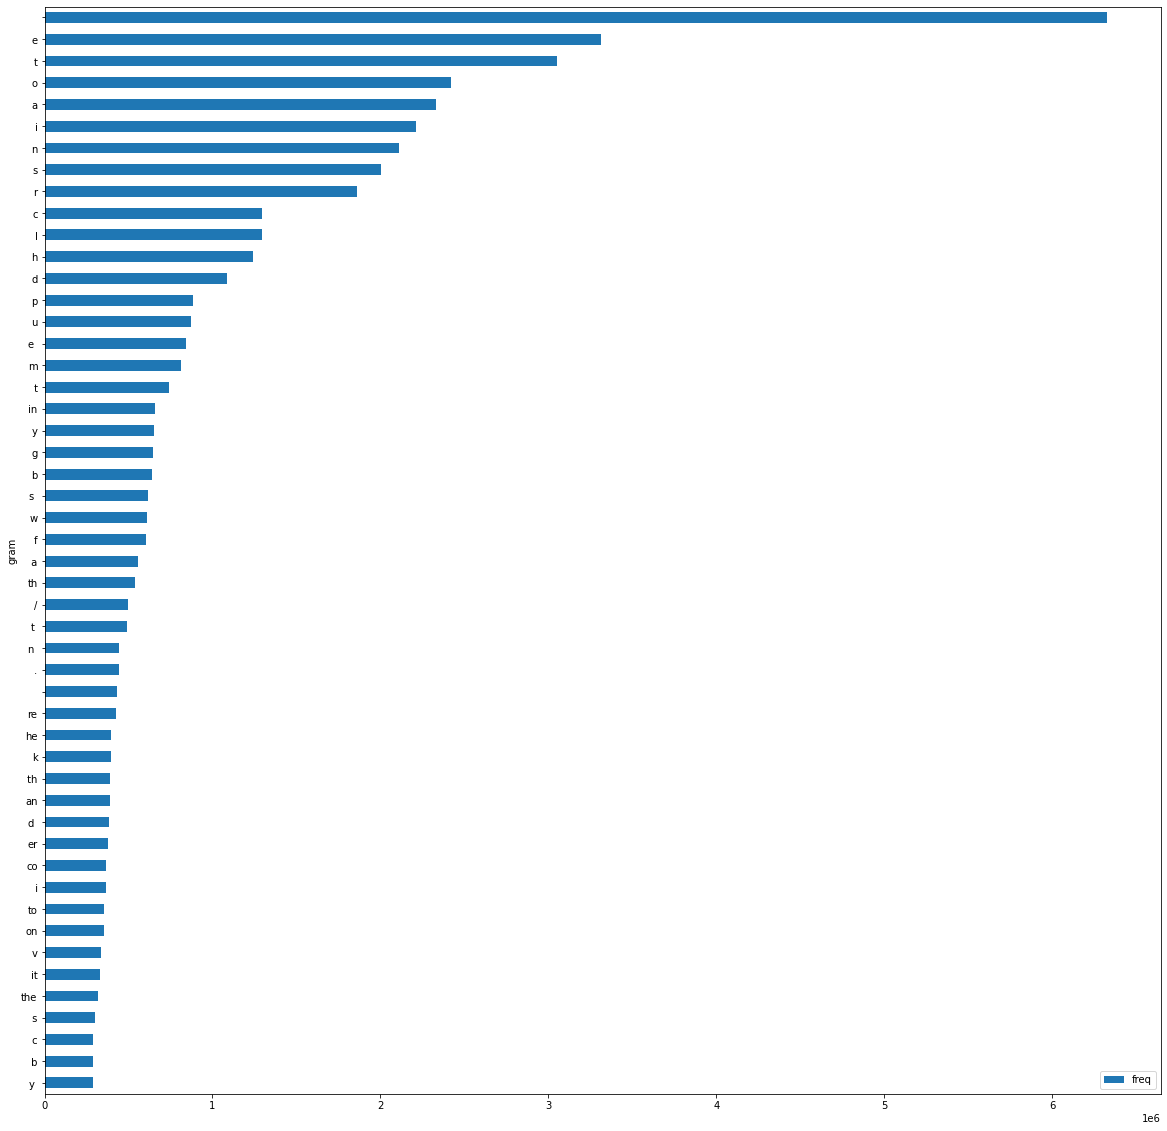

In [11]:
p = all_df[:50][['gram','freq']].plot.barh(x='gram'); p.invert_yaxis();


In [12]:
all_counters1['_']

65857

In [13]:
lexicon = {'a','xyz','ij'}
lexlist = list(lexicon)
lexlist.sort(key=len,reverse=True)
lexlist

['xyz', 'ij', 'a']

In [14]:
alphalex = {' ','-','.','!'}
tokenize_with_lexicon(alphalex,"I know-you know. We know!")

['I', ' ', 'know', '-', 'you', ' ', 'know', '.', ' ', 'We', ' ', 'know', '!']

In [15]:
counters2 = grams_init(max_n)
alphalex = {' '}

all_tokens = {}

for text in feeds_df['text']:
    text = preprocess_text(text)
    tokens = tokenize_with_lexicon(alphalex,text)
    for token in tokens:
        if not token in alphalex: #skip known tokens 
            text_grams_count(counters2,token,max_n)
        count(all_tokens,token)


In [16]:
token_df = pd.DataFrame([(gram, all_tokens[gram]) for gram in all_tokens],columns=['gram','freq'])
token_df['log'] = np.log10(token_df['freq'])
token_df.sort_values('freq',ascending=False,inplace=True)

367689


/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


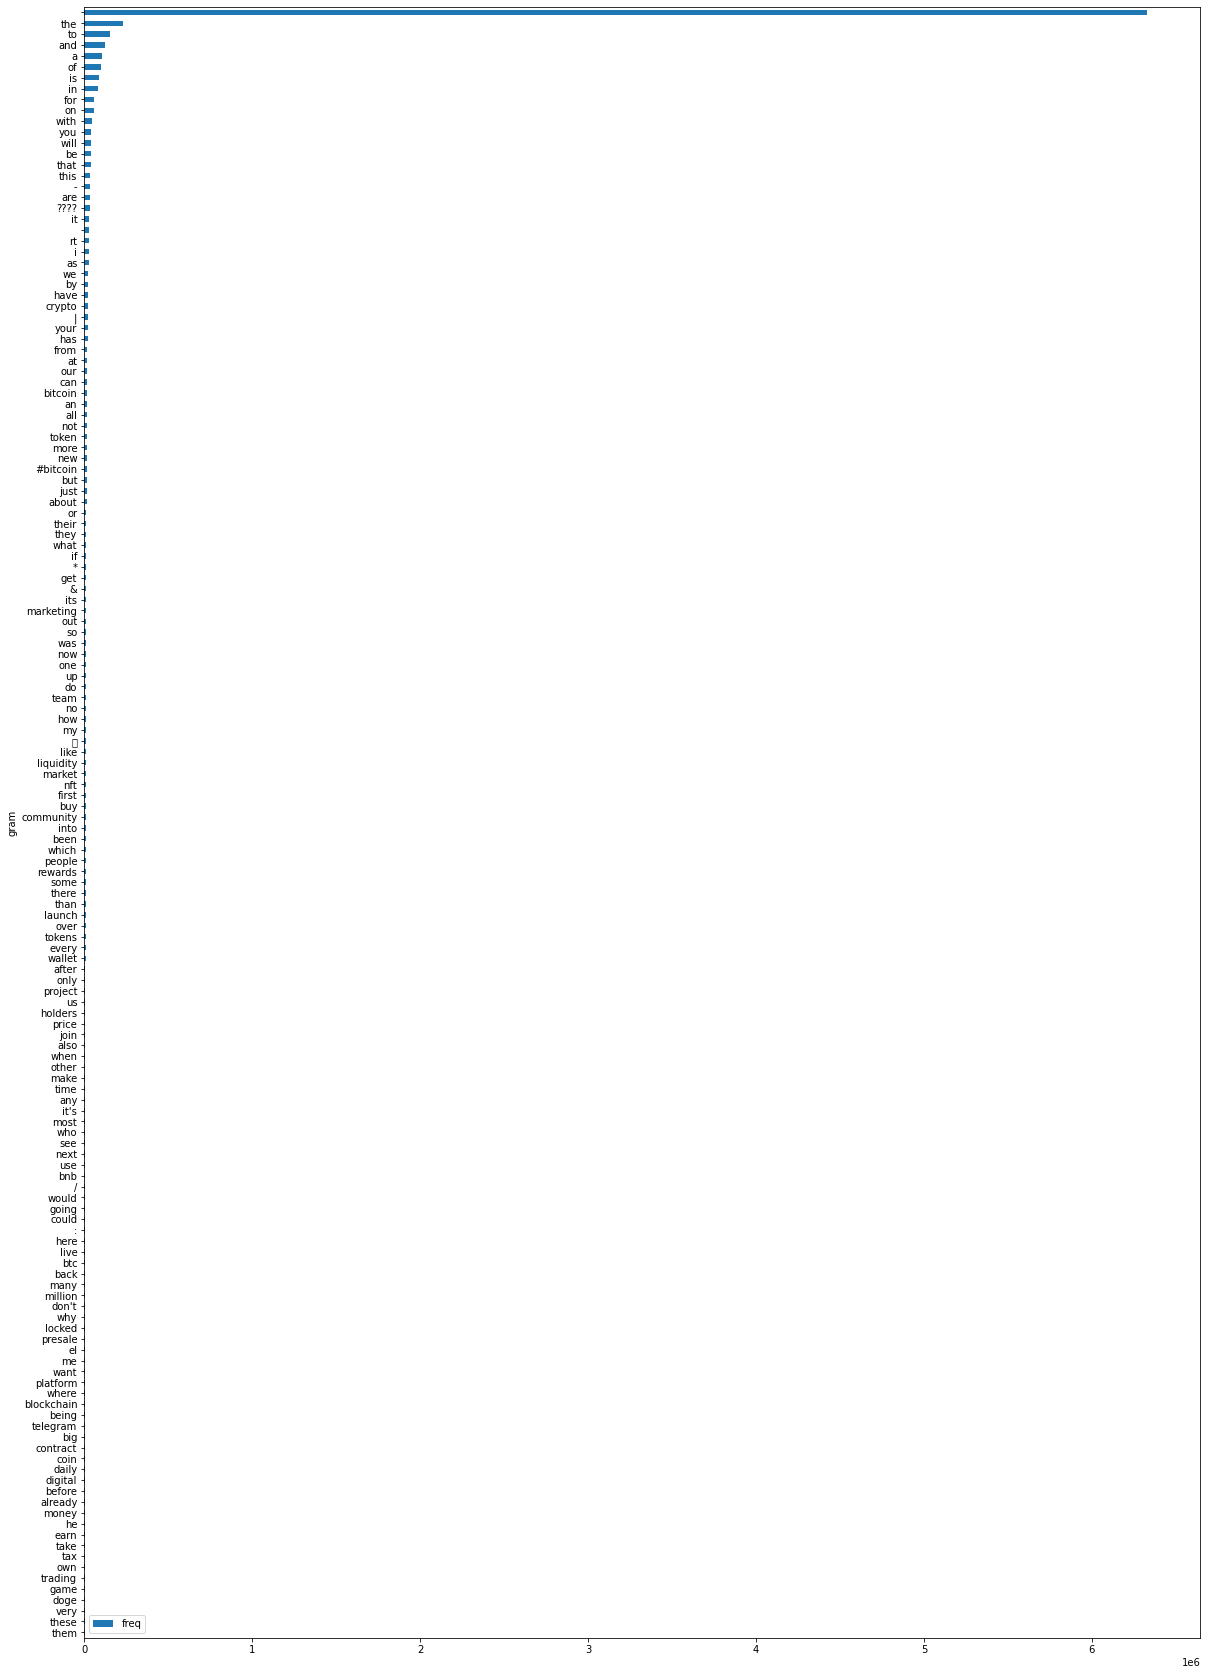

In [17]:
plt.rcParams["figure.figsize"] = (20,30)
print(len(token_df))
p = token_df[:150][['gram','freq']].plot.barh(x='gram'); p.invert_yaxis();


/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


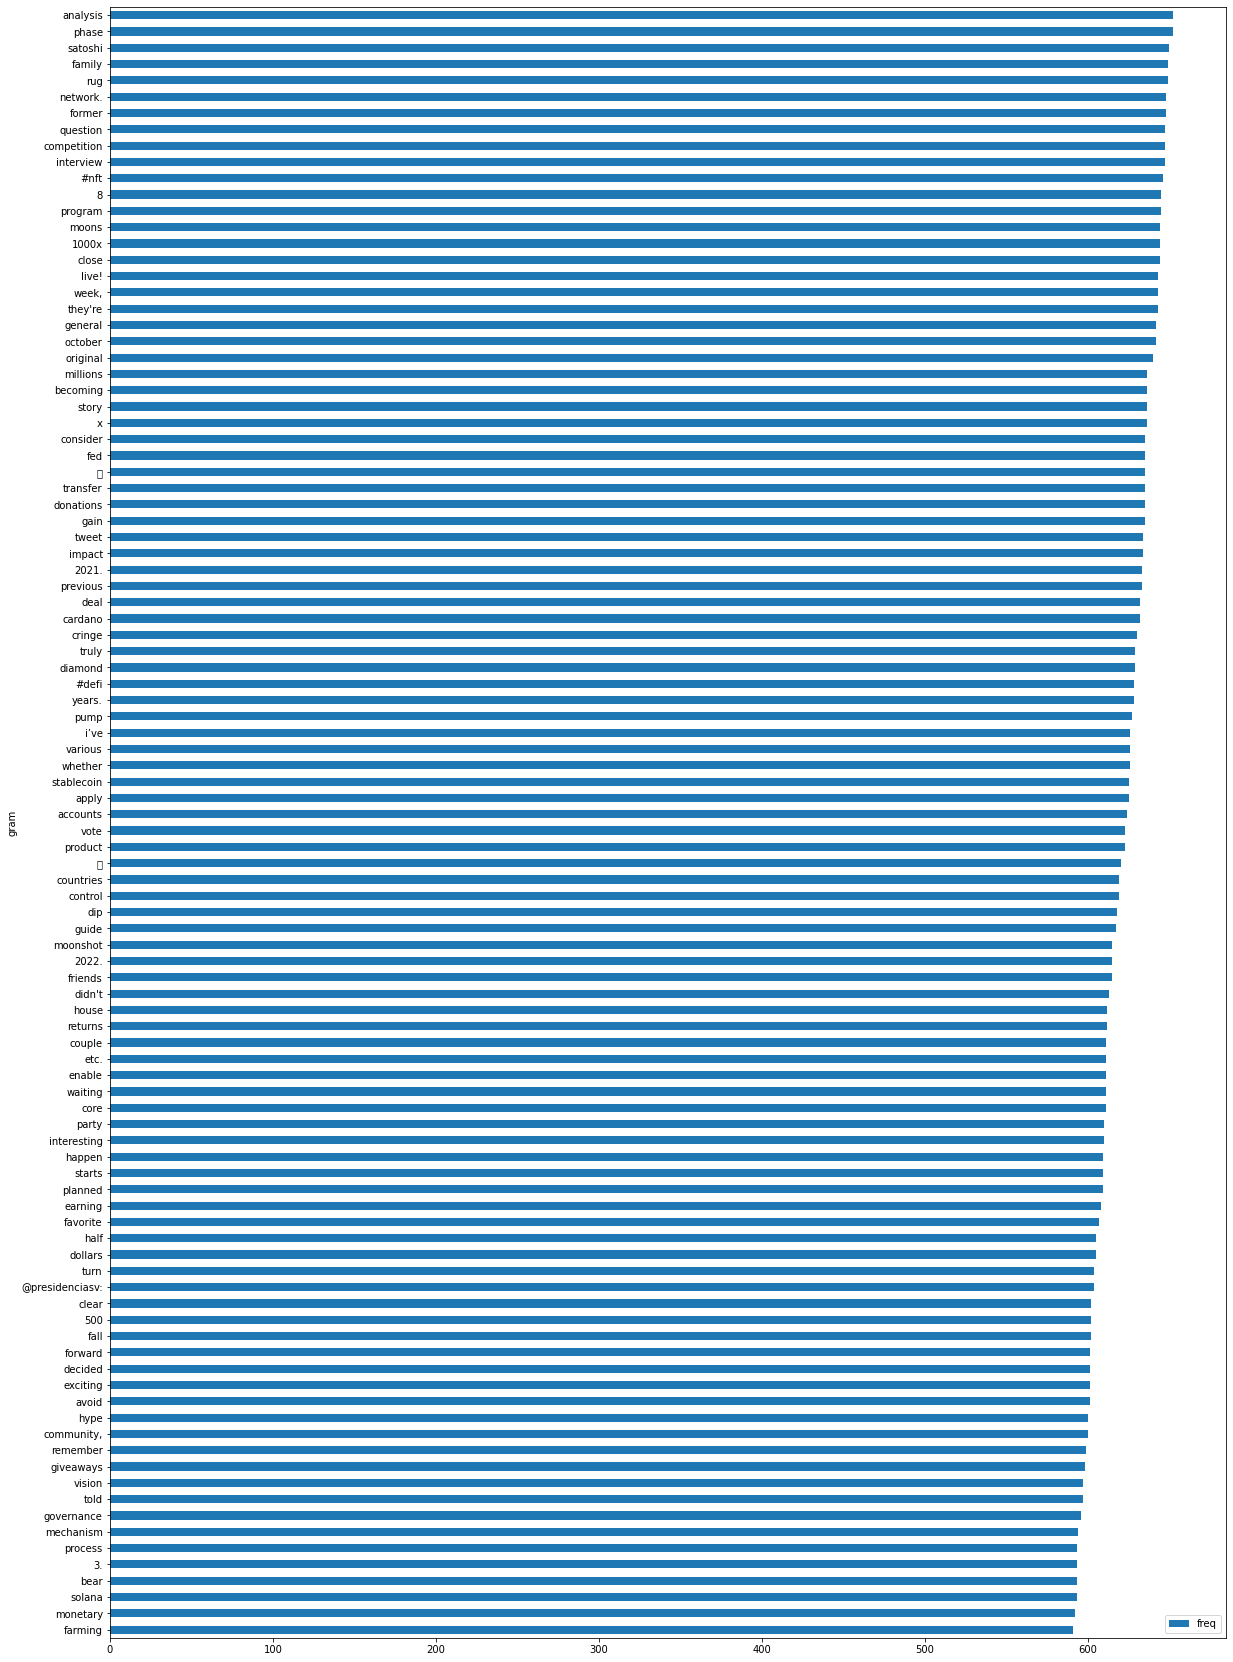

In [18]:
#367689
plt.rcParams["figure.figsize"] = (20,30)
p = token_df[1000:1100][['gram','freq']].plot.barh(x='gram'); p.invert_yaxis();


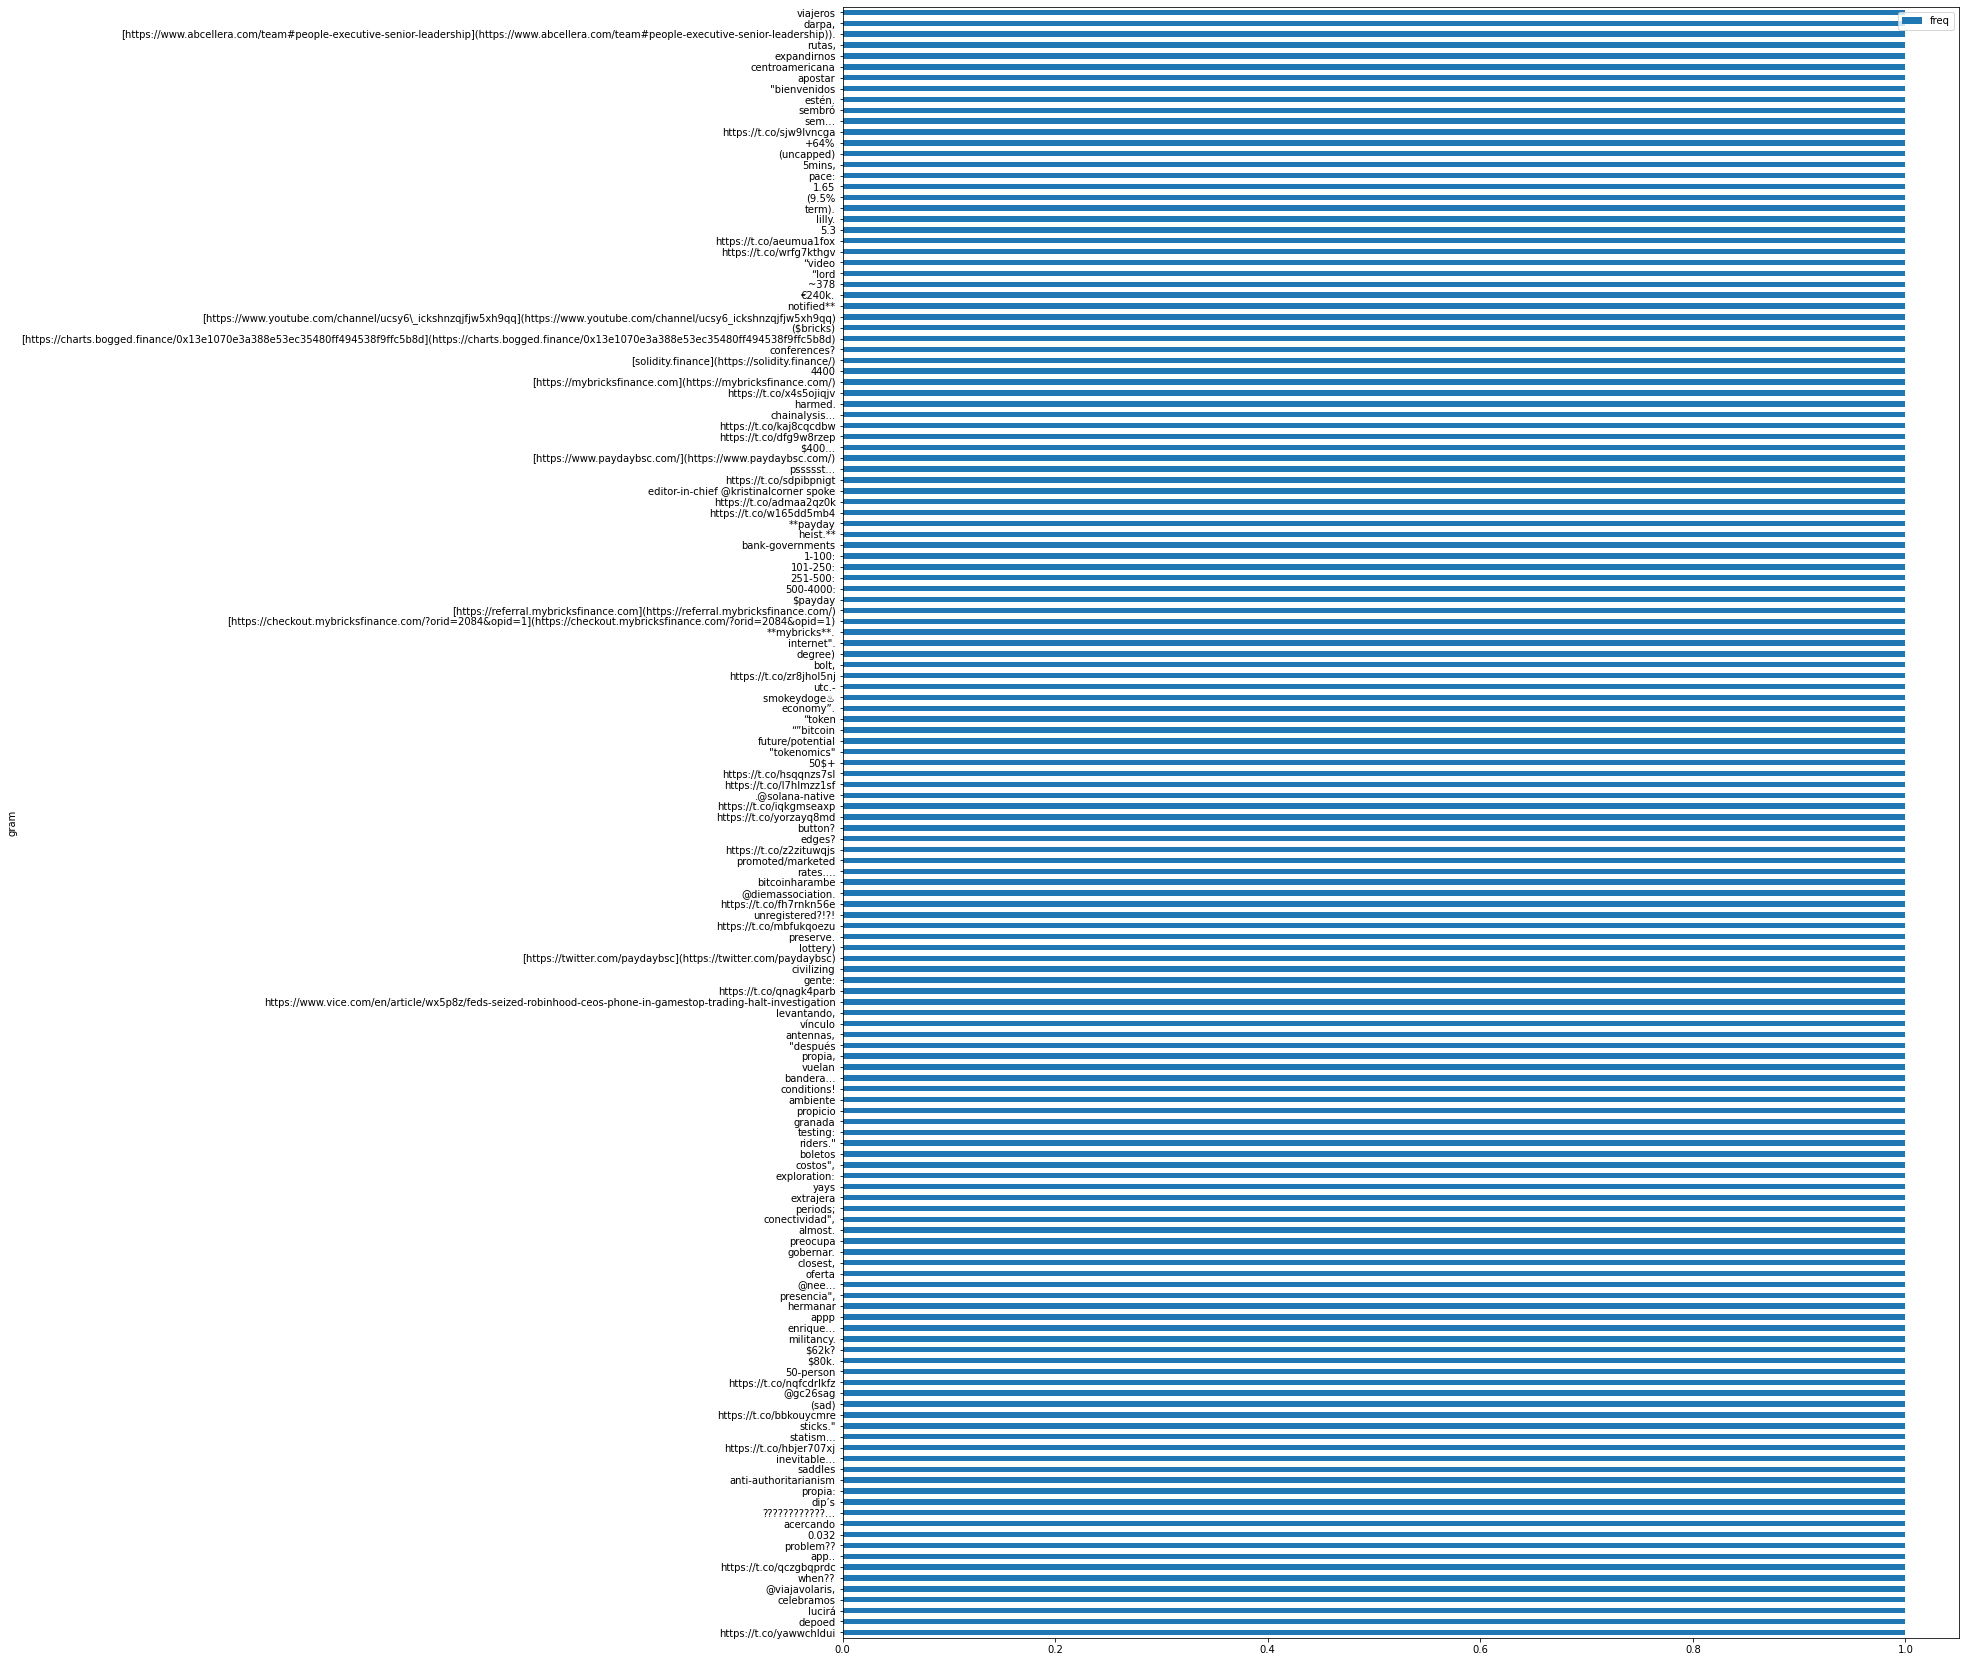

In [19]:
plt.rcParams["figure.figsize"] = (20,30)
p = token_df[-150:][['gram','freq']].plot.barh(x='gram'); p.invert_yaxis();


In [20]:
dfs = []
for i in range(len(counters2)):
    counter = counters2[i]
    df = pd.DataFrame([(gram, counter[gram]) for gram in counter],columns=['gram','freq'])
    df['log'] = np.log10(df['freq'])
    df.sort_values('freq',ascending=False,inplace=True)
    df.title = str(i)
    dfs.append(df)

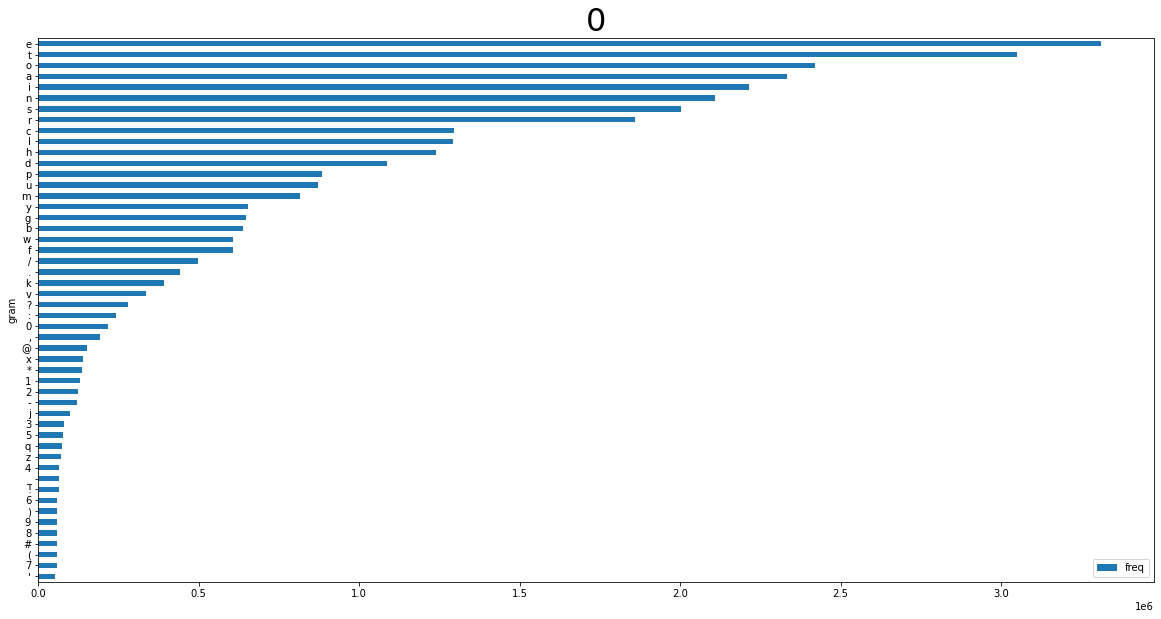

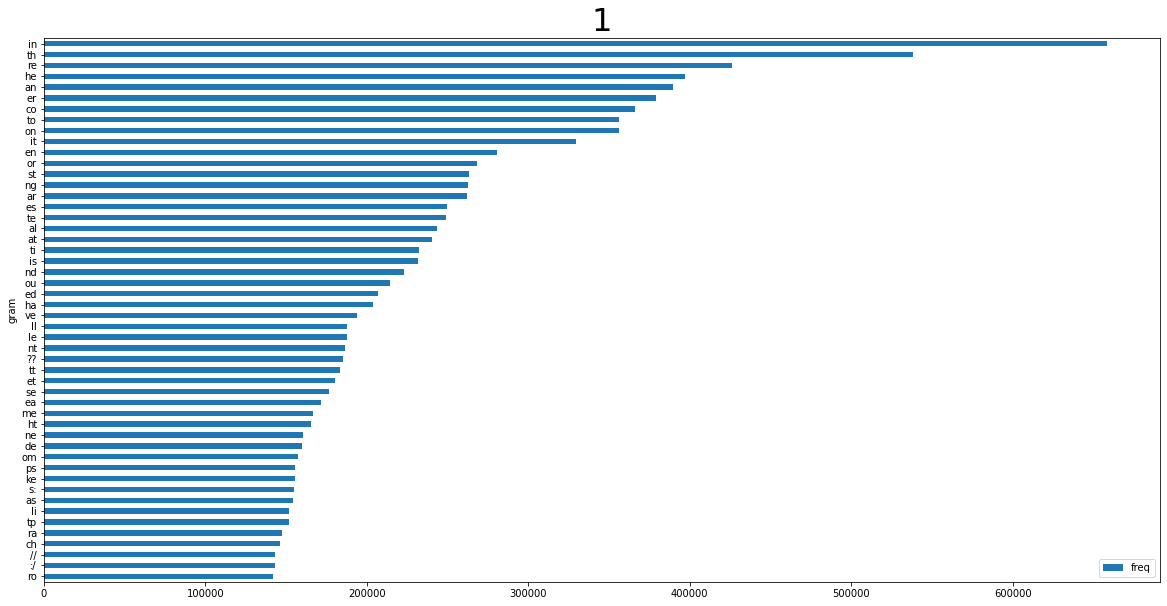

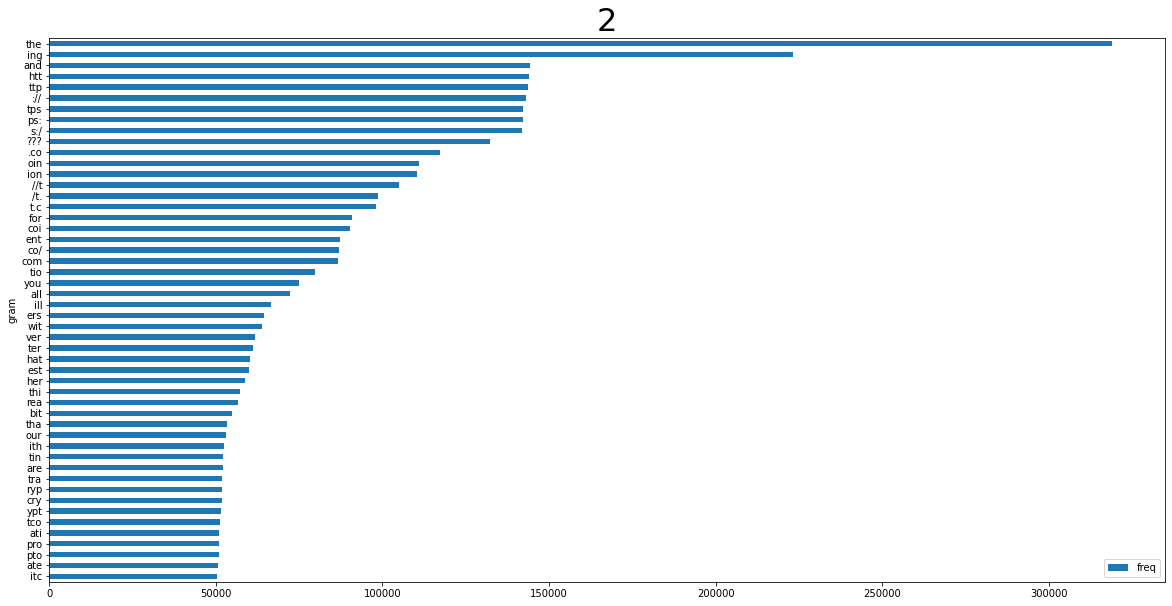

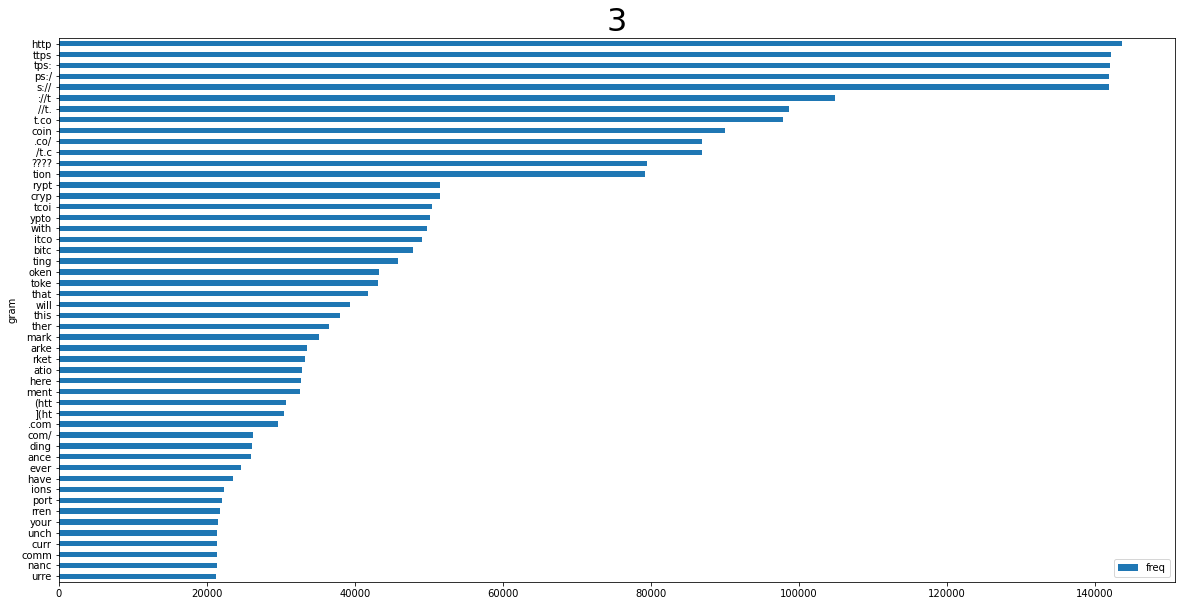

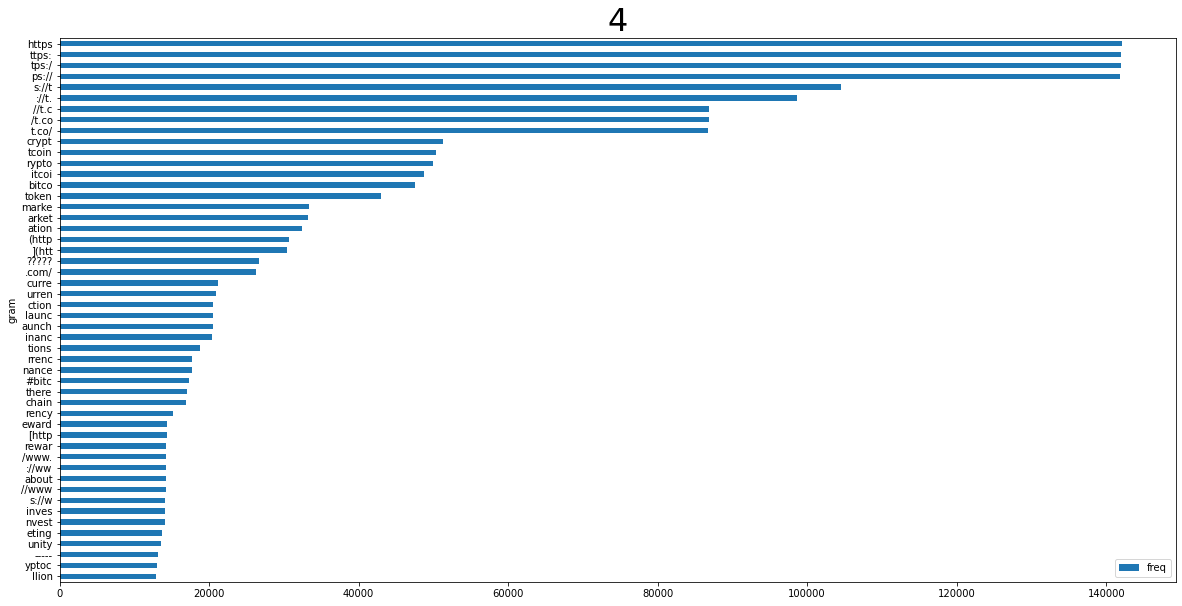

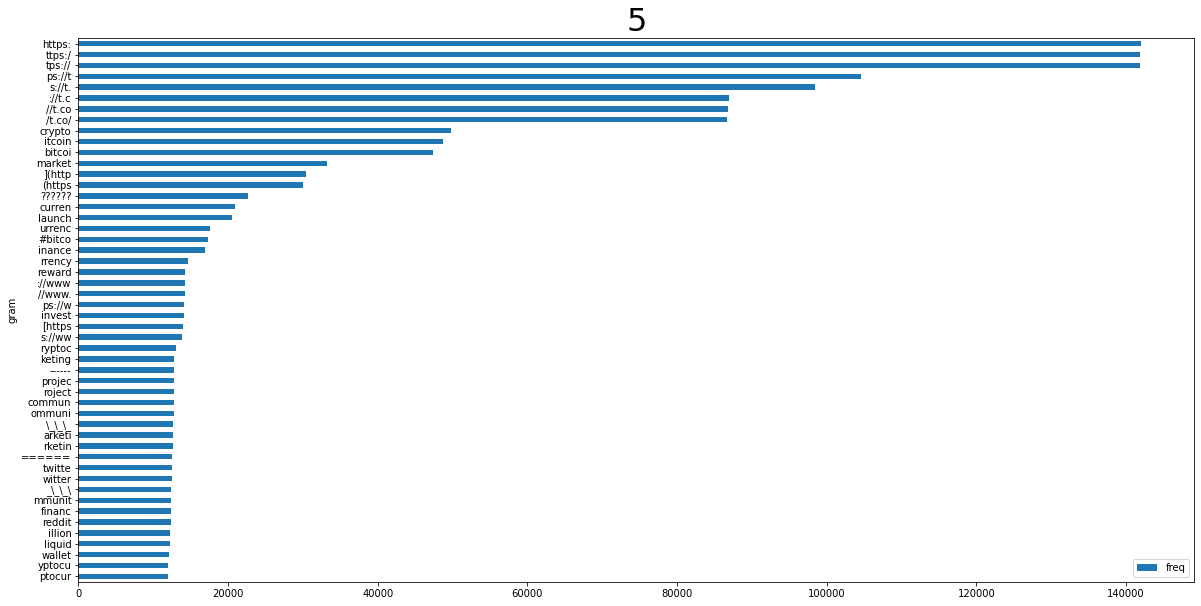

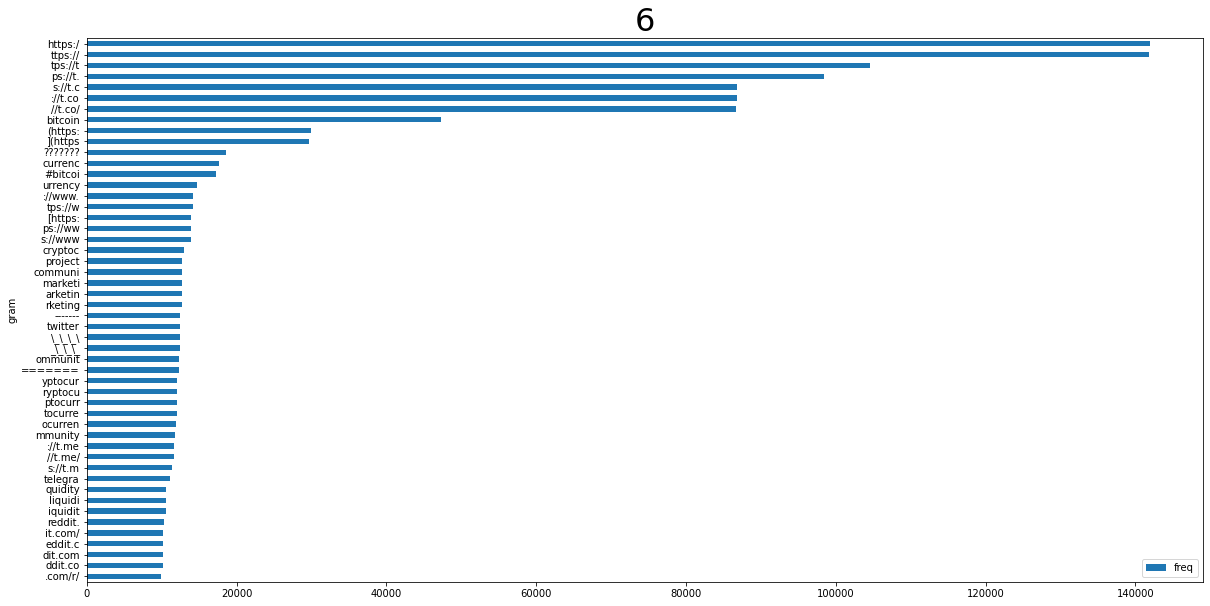

In [21]:
plt.rcParams["figure.figsize"] = (20,10)
for df in dfs:
    p = df[:50][['gram','freq']].plot.barh(x='gram'); p.invert_yaxis();
    p.set_title(df.title,fontsize = 32)
    plt.show()


In [22]:
all_counters2 = {}
for counter in counters2:
    all_counters2 = merge_two_dicts(all_counters2,counter)


In [23]:
all_df = pd.DataFrame([(gram, all_counters2[gram]) for gram in all_counters2],columns=['gram','freq'])
all_df['log'] = np.log10(all_df['freq'])
all_df.sort_values('freq',ascending=False,inplace=True)
all_df


,gram,freq,log
10,e,3311340,6.520004
1,t,3050884,6.484426
19,o,2419007,6.383637
4,a,2332210,6.367768
13,i,2214966,6.345367
...,...,...,...
1987367,/6nku,1,0.000000
1987368,6nkuk,1,0.000000
1987369,nkuks,1,0.000000
1987370,kuks9,1,0.000000


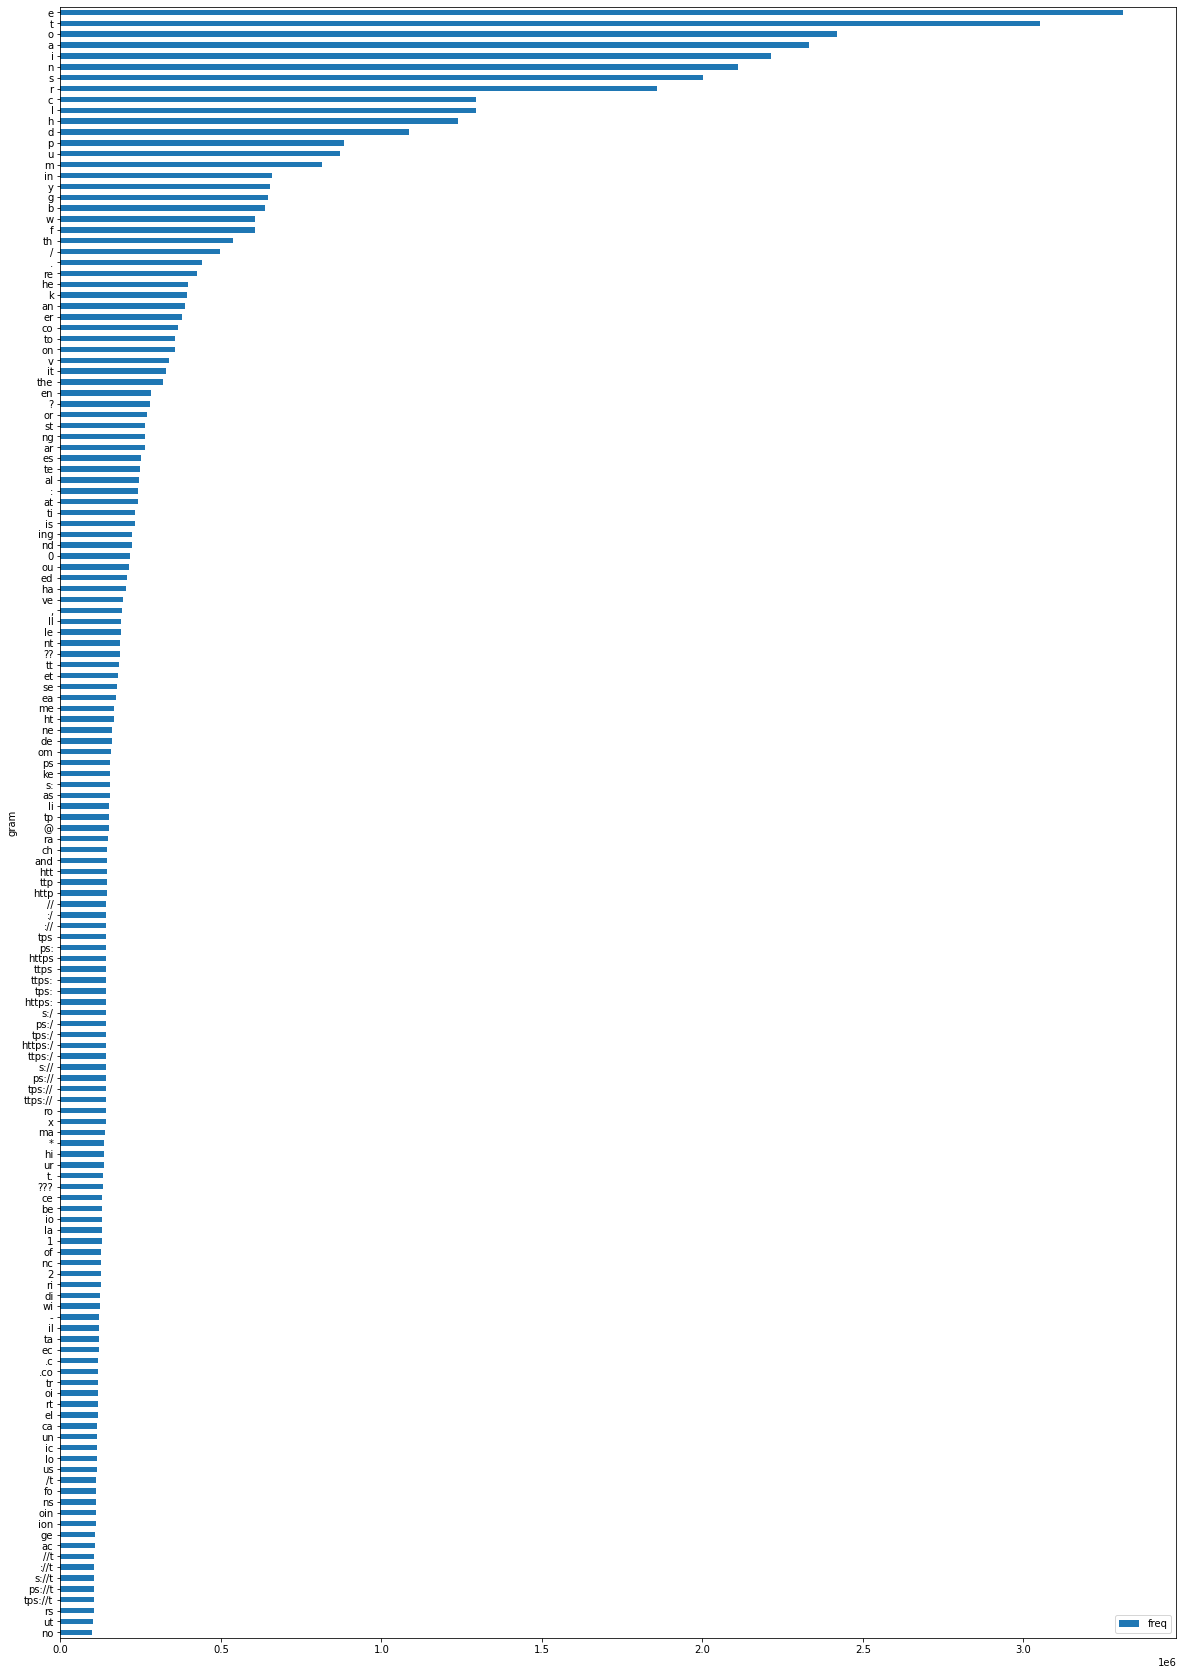

In [24]:
plt.rcParams["figure.figsize"] = (20,30)
p = all_df[:150][['gram','freq']].plot.barh(x='gram'); p.invert_yaxis();


In [25]:
set(list(token_df[:100]['gram']))

{' ',
 '#bitcoin',
 '&',
 '*',
 '-',
 '????',
 'a',
 'about',
 'after',
 'all',
 'also',
 'an',
 'and',
 'are',
 'as',
 'at',
 'be',
 'been',
 'bitcoin',
 'but',
 'buy',
 'by',
 'can',
 'community',
 'crypto',
 'do',
 'every',
 'first',
 'for',
 'from',
 'get',
 'has',
 'have',
 'holders',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'it',
 'its',
 'join',
 'just',
 'launch',
 'like',
 'liquidity',
 'make',
 'market',
 'marketing',
 'more',
 'my',
 'new',
 'nft',
 'no',
 'not',
 'now',
 'of',
 'on',
 'one',
 'only',
 'or',
 'other',
 'our',
 'out',
 'over',
 'people',
 'price',
 'project',
 'rewards',
 'rt',
 'so',
 'some',
 'team',
 'than',
 'that',
 'the',
 'their',
 'there',
 'they',
 'this',
 'time',
 'to',
 'token',
 'tokens',
 'up',
 'us',
 'wallet',
 'was',
 'we',
 'what',
 'when',
 'which',
 'will',
 'with',
 'you',
 'your',
 '|',
 '\u200b',
 '✅'}

In [26]:
#TODO with top 1000 grams
counters3 = grams_init(max_n)
alphalex3 = set(list(token_df[:100]['gram']))

all_tokens3 = {}

for text in feeds_df['text']:
    text = preprocess_text(text)
    tokens = tokenize_with_lexicon(alphalex3,text)
    for token in tokens:
        if not token in alphalex3: #skip known tokens 
            text_grams_count(counters3,token,max_n)
        count(all_tokens3,token)


In [27]:
token3_df = pd.DataFrame([(gram, all_tokens3[gram]) for gram in all_tokens3],columns=['gram','freq'])
token3_df['log'] = np.log10(token3_df['freq'])
token3_df.sort_values('freq',ascending=False,inplace=True)

247415


/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


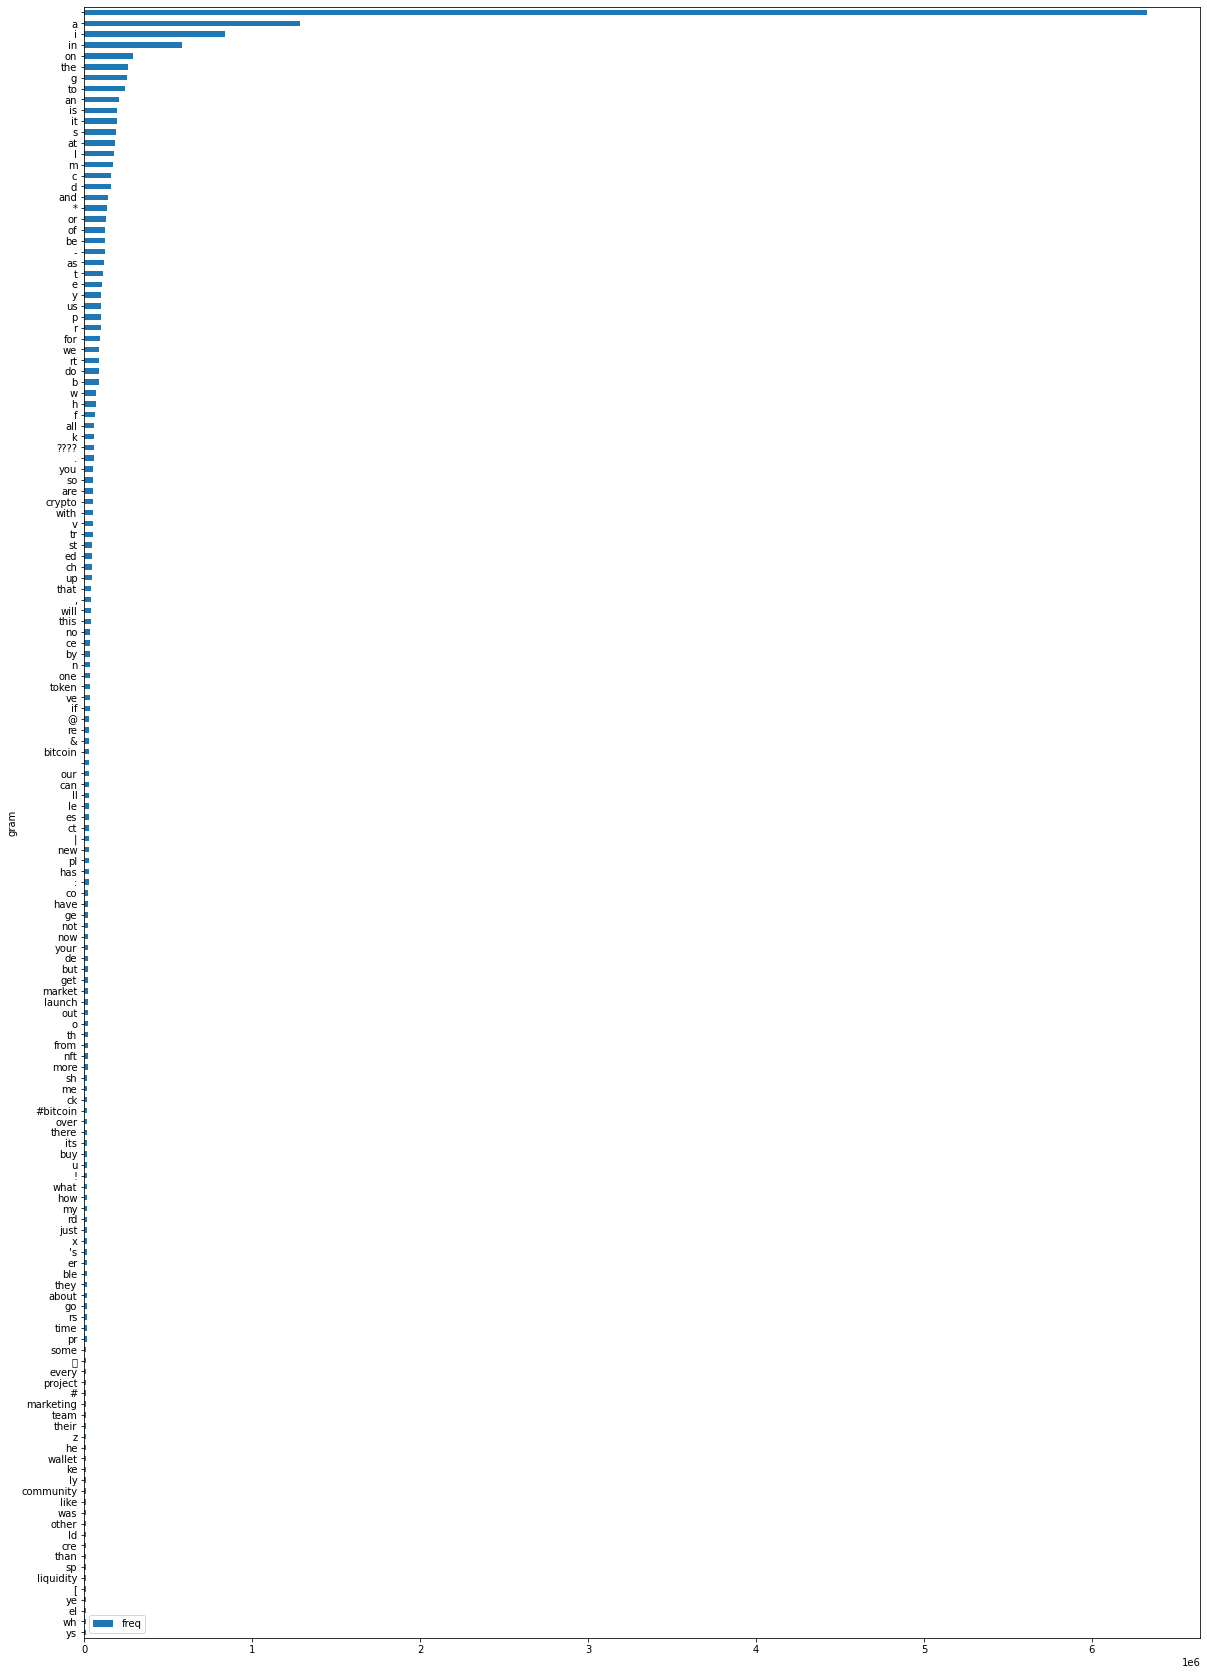

In [28]:
plt.rcParams["figure.figsize"] = (20,30)
print(len(token3_df))
p = token3_df[:150][['gram','freq']].plot.barh(x='gram'); p.invert_yaxis();


In [29]:
counters1[1]['o ']

276357

In [30]:
def plot_profile_probabilities(counters,text,max_n,plot=True,debug=False):
    df = pd.DataFrame(profile_probabilities(counters,text,max_n,debug=debug),columns=['pos','char','p+','p-'])
    #print(df)
    df.set_index('pos',inplace=True)
    if plot:
        plt.rcParams["figure.figsize"] = (20,5)
        plot_profile( df[['char','p+']],text)
        plot_profile( df[['char','p-']],text)
    return df

print(merge_grams_at(['ab','bc','cd'],0))
print(merge_grams_at(['ab','bc','cd'],1))
print(merge_grams_at(['ab','bc','cd'],2))
print(merge_grams_at(['ab','bc','cd','de'],0))
print(merge_grams_at(['ab','bc','cd','de'],1))
print(merge_grams_at(['ab','bc','cd','de'],2))
print(merge_grams_at(['ab','bc','cd','de'],3))


['abc', 'cd']
['abcd']
['ab', 'bcd']
['abc', 'cd', 'de']
['abcd', 'de']
['ab', 'bcde']
['ab', 'bc', 'cde']


In [31]:
df = pd.DataFrame(profile_probabilities(all_counters1,"the cat sits on a mat",3,debug=True),columns=['pos','char','p+','p-'])
df.set_index('pos',inplace=True)
df

Forw 0-1:'th'-'t'=h=>0.176495402643955
Back 1-4:'he '-'e '=h=>0.2828593881680244
Forw 0-2:'the'-'th'=e=>0.5924801334157896
Back 2-5:'e c'-' c'=e=>0.17440343637170913
Forw 1-3:'he '-'he'= =>0.6014123126241192
Back 3-6:' ca'-'ca'= =>0.4497198903994834
Forw 2-4:'e c'-'e '=c=>0.06006071144520976
Back 4-7:'cat'-'at'=c=>0.04337285266953047
Forw 3-5:' ca'-' c'=a=>0.17738410333896654
Back 5-8:'at '-'t '=a=>0.15579588931940802
Forw 4-6:'cat'-'ca'=t=>0.09101380477844291
Back 6-9:'t s'-' s'=t=>0.07480807058579102
Forw 5-7:'at '-'at'= =>0.3195327541969369
Back 7-10:' si'-'si'= =>0.16797200132371964
Forw 6-8:'t s'-'t '=s=>0.04526330942836925
Back 8-11:'sit'-'it'=s=>0.04756975642924792
Forw 7-9:' si'-' s'=i=>0.056129510048020054
Back 9-12:'its'-'ts'=i=>0.17663817663817663
Forw 8-10:'sit'-'si'=t=>0.15715159598471706
Back 10-13:'ts '-'s '=t=>0.09955078502876895
Forw 9-11:'its'-'it'=s=>0.05081473566623765
Back 11-14:'s o'-' o'=s=>0.1480360540880897
Forw 10-12:'ts '-'ts'= =>0.6461010868418275
Back 12-15

,char,p+,p-
pos,,,
1,h,0.176495,0.282859
2,e,0.592480,0.174403
3,,0.601412,0.449720
4,c,0.060061,0.043373
5,a,0.177384,0.155796
6,t,0.091014,0.074808
7,,0.319533,0.167972
8,s,0.045263,0.047570
9,i,0.056130,0.176638


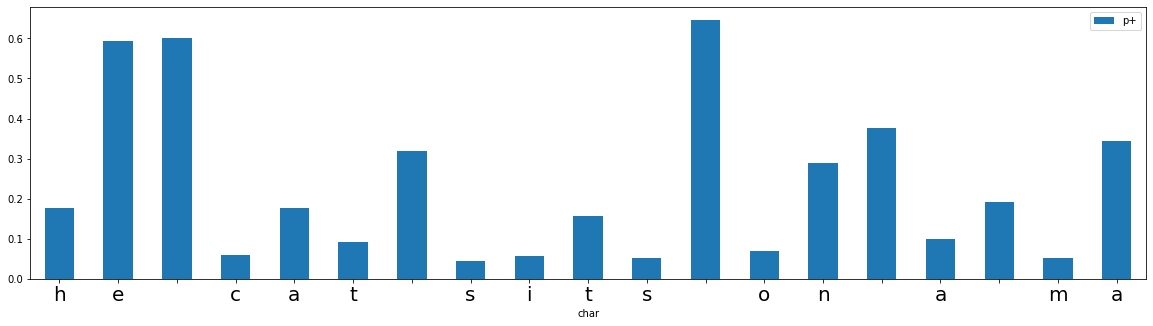

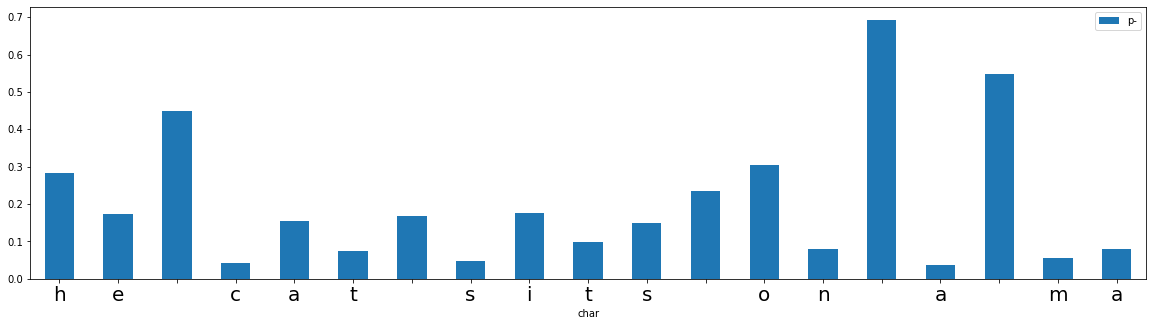

In [32]:
plt.rcParams["figure.figsize"] = (20,5)
p = df[['char','p+']].plot.bar(x='char'); p = plt.xticks(rotation='horizontal',fontsize=20)
p = df[['char','p-']].plot.bar(x='char'); p = plt.xticks(rotation='horizontal',fontsize=20)


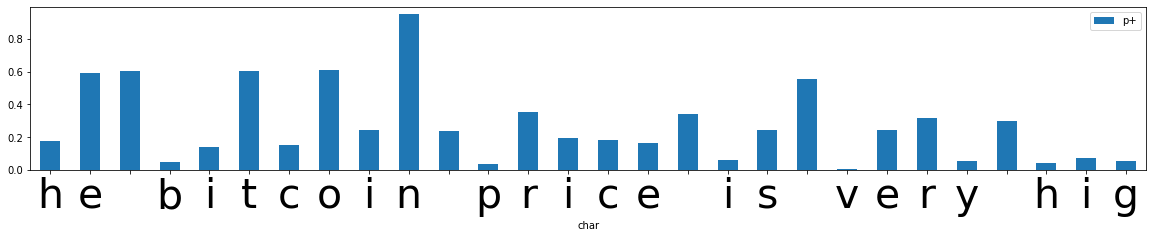

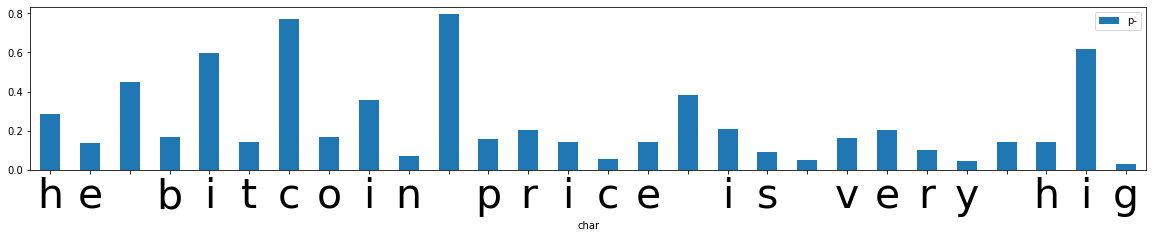

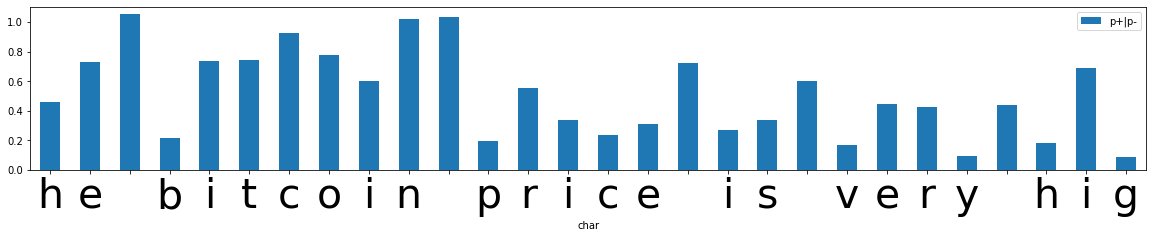

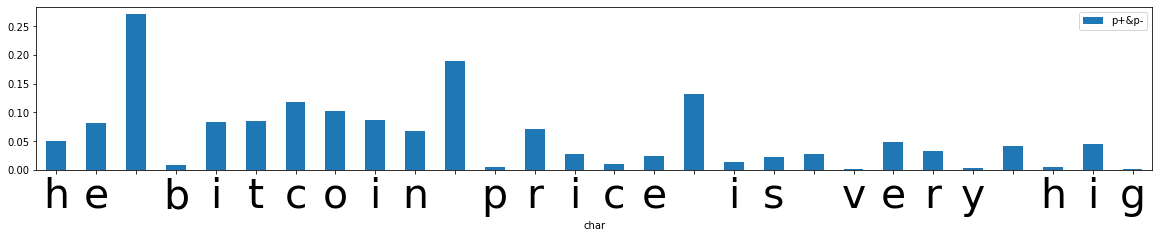

In [33]:
df = plot_profile_probabilities(all_counters1,"the bitcoin price is very high",3,plot=True,debug=False)
df['p+|p-']=df['p+'] + df['p-']
df['p+&p-']=df['p+'] * df['p-']
plot_profile(df[['char','p+|p-']],"the bitcoin price is very high")
plot_profile(df[['char','p+&p-']],"the bitcoin price is very high")


In [34]:
sdf = None
for i in range(2,6):
    df = plot_profile_probabilities(all_counters1,feeds_df.loc[0]['text'].lower(),i,False)
    if sdf is None:
        sdf = df
        sdf['sum_p+'] = df['p+']
        sdf['mul_p+'] = df['p+']
        sdf['sum_p-'] = df['p-']
        sdf['mul_p-'] = df['p-']
        sdf.drop('p+', inplace=True, axis=1)
        sdf.drop('p-', inplace=True, axis=1)
    else:
        sdf['sum_p+'] = sdf['sum_p+'] + df['p+']
        sdf['mul_p+'] = sdf['sum_p+'] * df['p+']
        sdf['sum_p-'] = sdf['sum_p-'] + df['p-']
        sdf['mul_p-'] = sdf['sum_p-'] * df['p-']

sdf['sum_p+|sum_p-'] = sdf['sum_p+'] + sdf['sum_p-']
sdf['sum_p+&sum_p-'] = sdf['sum_p+'] * sdf['sum_p-']
sdf['mul_p+|mul_p-'] = sdf['mul_p+'] + sdf['mul_p-']
sdf['mul_p+&mul_p-'] = sdf['mul_p+'] * sdf['mul_p-']


/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129418 (\N{FOX FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


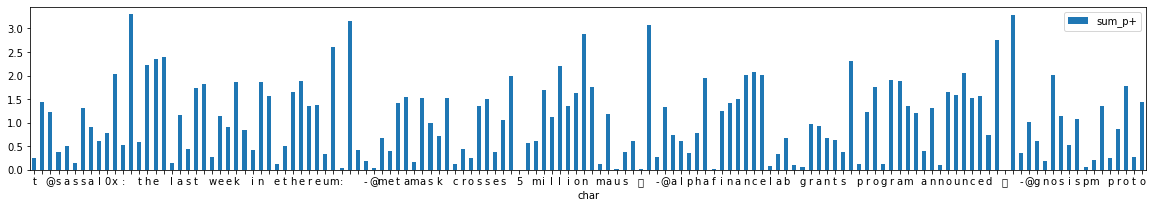

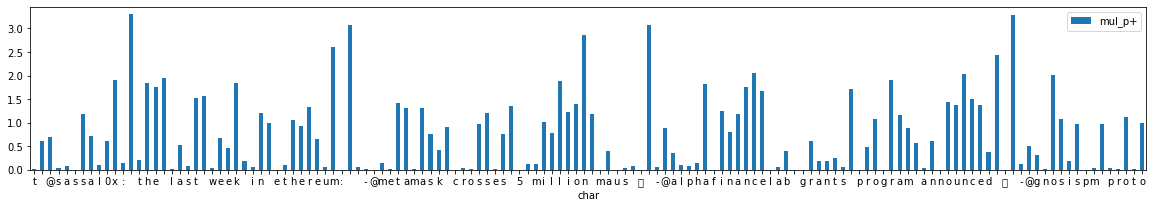

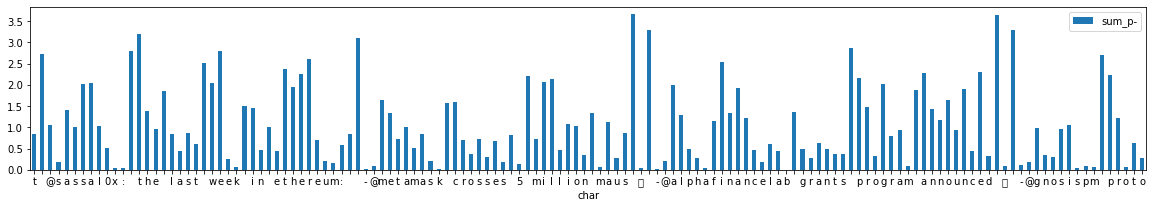

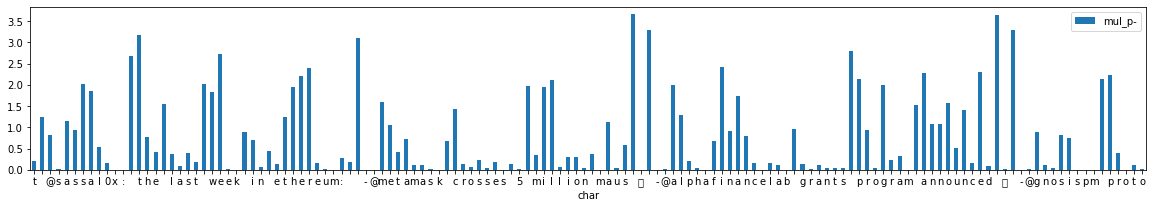

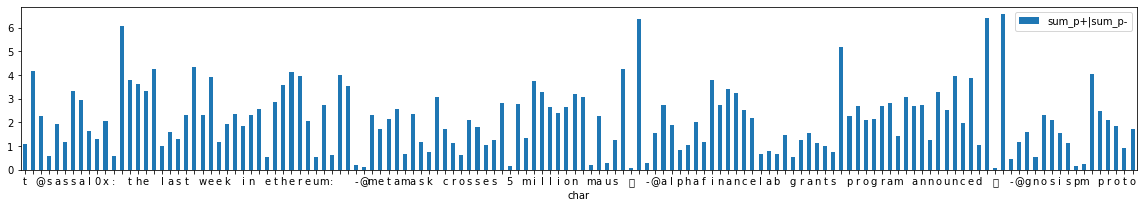

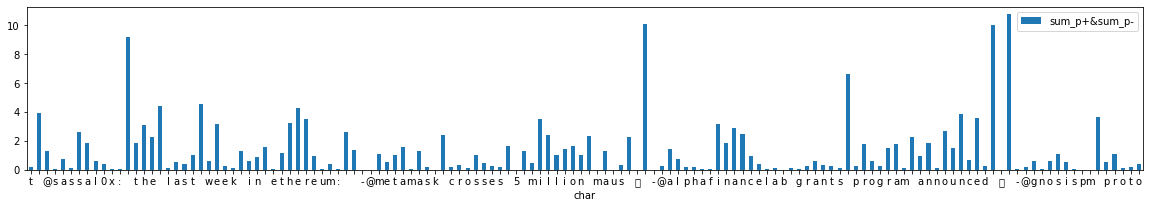

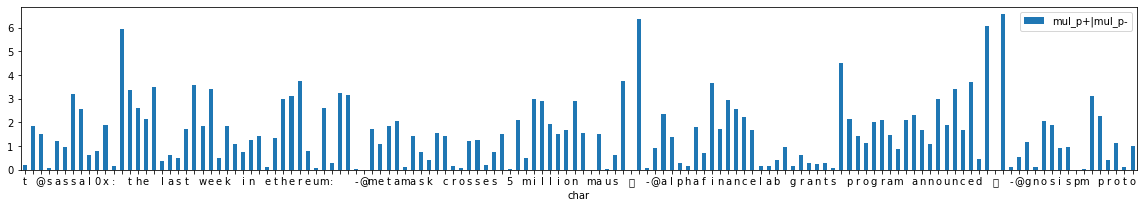

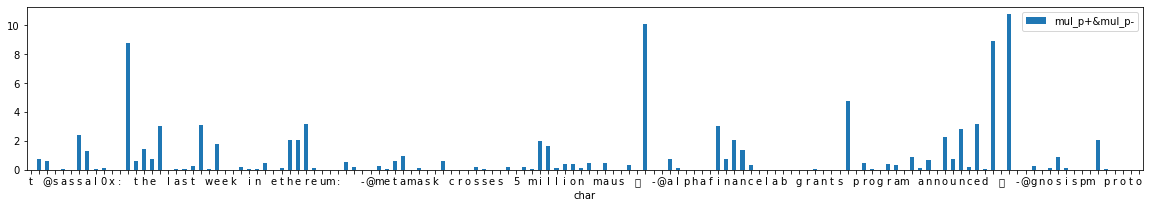

In [35]:
plot_profile(sdf[['char','sum_p+']],feeds_df.loc[0]['text'].lower())
plot_profile(sdf[['char','mul_p+']],feeds_df.loc[0]['text'].lower())
plot_profile(sdf[['char','sum_p-']],feeds_df.loc[0]['text'].lower())
plot_profile(sdf[['char','mul_p-']],feeds_df.loc[0]['text'].lower())

plot_profile(sdf[['char','sum_p+|sum_p-']],feeds_df.loc[0]['text'].lower())
plot_profile(sdf[['char','sum_p+&sum_p-']],feeds_df.loc[0]['text'].lower())
plot_profile(sdf[['char','mul_p+|mul_p-']],feeds_df.loc[0]['text'].lower())
plot_profile(sdf[['char','mul_p+&mul_p-']],feeds_df.loc[0]['text'].lower())


In [36]:
df = plot_profile_probabilities(all_counters1,feeds_df.loc[0]['text'].lower(),3,False)
df

,char,p+,p-
pos,,,
1,t,0.062611,0.280915
2,,0.426710,0.797510
3,@,0.065565,0.036505
4,s,0.099050,0.003163
5,a,0.175981,0.214452
...,...,...,...
134,p,0.031052,0.358792
135,r,0.350515,0.078183
136,o,0.513594,0.013536


In [37]:
print(all_counters1['@sa']/all_counters1['@s'])
print(all_counters1['rot']/all_counters1['ro'])
print(all_counters1['oto']/all_counters1['ot'])



0.1759809750297265
0.04469455192476064
0.05956968529222865


In [38]:
print_grams(counters1,"year 2022. 2021 is over.",2)


ye 23185
ea 171646
ar 262170
r  268320
 2 34170
20 26239
02 13539
22 7377
2. 4013
.  208107
 2 34170
20 26239
02 13539
21 10498
1  14556
 i 364853
is 231598
s  615073
 o 287457
ov 40253
ve 193907
er 378807
r. 17528


In [39]:
marge_grams(all_counters1,"year 2022. 2021 is over.",2,2)


ye 23185
ea 171646
ar 262170
r  268320
 2 34170
20 26239
02 13539
22 7377
2. 4013
.  208107
 2 34170
20 26239
02 13539
21 10498
1  14556
 i 364853
is 231598
s  615073
 o 287457
ov 40253
ve 193907
er 378807
r. 17528
0 ==> s  615073
ye 23185
ea 171646
ar 262170
r  268320
 2 34170
20 26239
02 13539
22 7377
2. 4013
.  208107
 2 34170
20 26239
02 13539
21 10498
1  14556
 i 364853
is o 5074
ov 40253
ve 193907
er 378807
r. 17528
1 ==> er 378807


In [40]:
counters_test = grams_init(max_n)
#text_grams_count(counters_test,"bob rob job",max_n)
text_grams_count(counters_test,"ababxyz",max_n)
counters_mis = counts2mis(counters_test[1],True)
counters_mis_df = pd.DataFrame([(gram, counters_mis[gram]) for gram in counters_mis],columns=['gram','mi'])
counters_mis_df['log'] = np.log10(counters_mis_df['mi'])
counters_mis_df.sort_values('mi',ascending=False,inplace=True)
counters_mis_df

ab a b 2 6 2 2
ba b a 1 6 2 1
bx b x 1 6 2 1
xy x y 1 6 1 1
yz y z 1 6 1 1


,gram,mi,log
3,xy,6.0,0.778151
4,yz,6.0,0.778151
0,ab,3.0,0.477121
1,ba,3.0,0.477121
2,bx,3.0,0.477121


In [41]:
counters_test[1]

{'ab': 2, 'ba': 1, 'bx': 1, 'xy': 1, 'yz': 1}

In [42]:
mis1 = counts2mis(counters1[1])

In [43]:
mis1['s.']

2.438062060028852

In [44]:
print_grams([None,mis1],"the blockchain is great",2)

th 5.891832418429718
he 3.994436969135652
e  1.6597529331265277
 b 2.984543518172481
bl 2.5090739166351503
lo 1.4892256167876545
oc 0.8012729355298925
ck 5.580358721588415
kc 0.7348280366774312
ch 3.7796499741292733
ha 2.9192300192541296
ai 0.7461836645230092
in 5.814439636547122
n  1.3655964572121528
 i 1.0763887520777022
is 2.157051860017478
s  2.002431654260816
 g 1.0721333089357208
gr 1.5708239490733118
re 2.8555187843012537
ea 0.9189902411479491
at 1.398471458831117


In [45]:
mis1_df = pd.DataFrame([(gram, mis1[gram]) for gram in mis1],columns=['gram','mi'])
mis1_df['log'] = np.log10(mis1_df['mi'])
mis1_df.sort_values('mi',ascending=False,inplace=True)

In [46]:
mis1_df

,gram,mi,log
15585,̼̗,4.115994e+07,7.614475
21695,边缘,4.115994e+07,7.614475
15586,̗̎,4.115994e+07,7.614475
20144,感激,4.115994e+07,7.614475
15587,̎̽,4.115994e+07,7.614475
...,...,...,...
21539,e$,2.876496e-04,-3.541136
6695,:o,2.806680e-04,-3.551807
9873,:e,2.563323e-04,-3.591197
12372,!e,2.061183e-04,-3.685883


<AxesSubplot:>

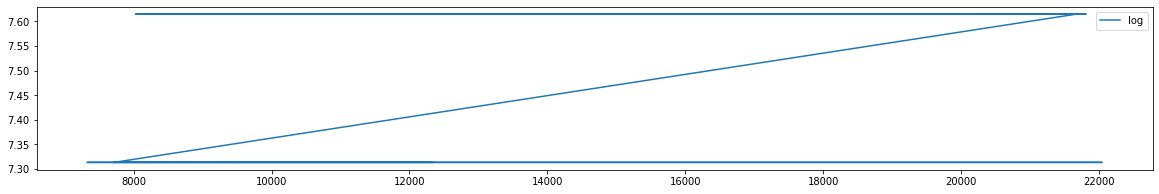

In [47]:
mis1_df[:200][['log']].plot()

In [48]:
model = model_grams_count_with_char_freedoms(feeds_df['text'].tolist(),max_n)


In [49]:
len(model)

3

In [54]:
len(model[1]['th'])

341

In [67]:
def profile_freedoms(model,text,max_n,debug=False):
    length = len(text)
    de_list = []
    for i in range(1,length-1):
        sym = text[i]
        #forward
        counters = model[1]
        start = i - (max_n-1)
        if start < 0:
            start = 0
        #gram = text[start:i]
        forw_gram = text[start:i+1]
        forw_freedom = len(counters[forw_gram]) if forw_gram in counters else 0
        #backward
        counters = model[2]
        end = i + max_n
        if end > length:
            end = length
        #gram = text[i+1:end]
        back_gram = text[i:end]
        back_freedom = len(counters[back_gram]) if back_gram in counters else 0
        if debug:
            print("Forw {}-{}:'{}':{}=>{}".format(start,i,forw_gram,sym,forw_freedom))
            print("Back {}-{}:'{}':{}=>{}".format(i,end,back_gram,sym,back_freedom))
        de_list.append((i,sym,forw_freedom,back_freedom))
    return de_list


def plot_profile_freedoms(model,text,max_n,plot=True,debug=False):
    df = pd.DataFrame(profile_freedoms(model,text,max_n,debug=debug),columns=['pos','char','f+','f-'])
    #print(df)
    df.set_index('pos',inplace=True)
    if plot:
        plt.rcParams["figure.figsize"] = (20,3)
        plot_profile( df[['char','f+']],text)
        plot_profile( df[['char','f-']],text)
    return df


In [64]:
profile_freedoms(model,"bitcoin",3,debug=True)

Forw 0-1:'bi':i=>263
Back 1-4:'itc':i=>32
Forw 0-2:'bit':t=>209
Back 2-5:'tco':t=>26
Forw 1-3:'itc':c=>204
Back 3-6:'coi':c=>82
Forw 2-4:'tco':o=>210
Back 4-7:'oin':o=>28
Forw 3-5:'coi':i=>247
Back 5-7:'in':i=>161


[(1, 'i', 263, 32),
 (2, 't', 209, 26),
 (3, 'c', 204, 82),
 (4, 'o', 210, 28),
 (5, 'i', 247, 161)]

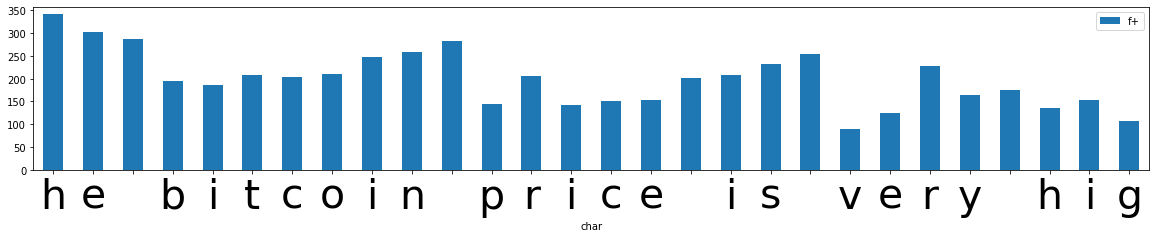

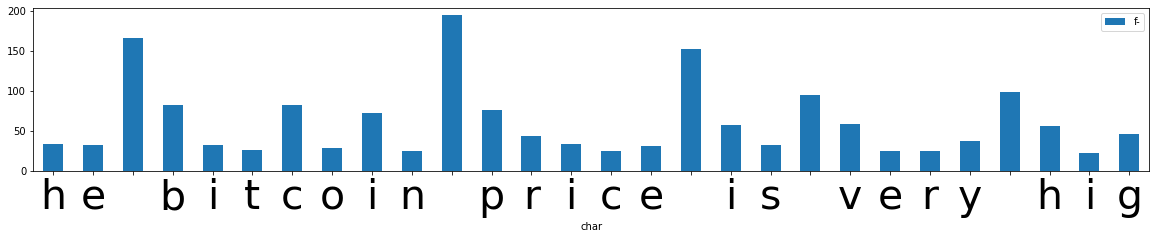

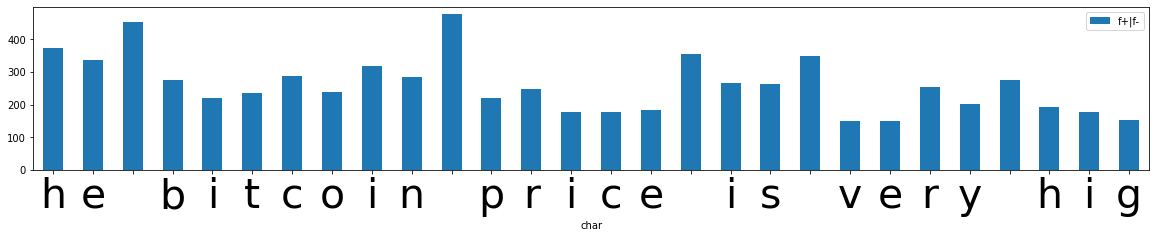

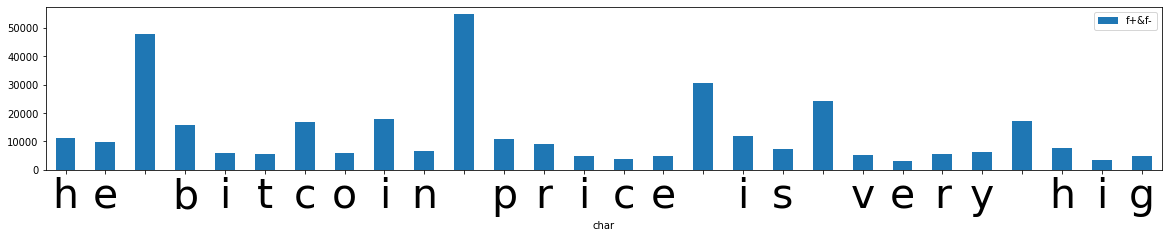

In [68]:
df = plot_profile_freedoms(model,"the bitcoin price is very high",3,plot=True,debug=False)
df['f+|f-']=df['f+'] + df['f-']
df['f+&f-']=df['f+'] * df['f-']
plot_profile(df[['char','f+|f-']],"the bitcoin price is very high")
plot_profile(df[['char','f+&f-']],"the bitcoin price is very high")


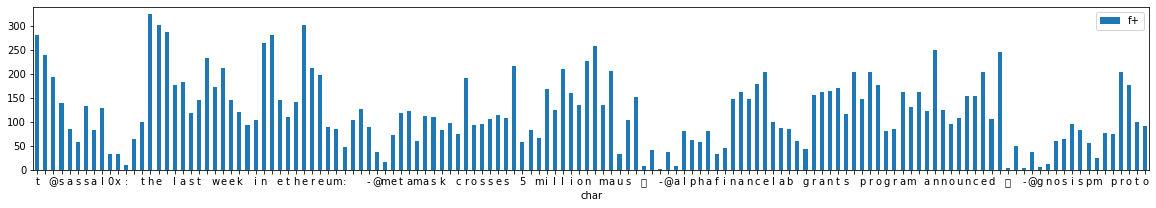

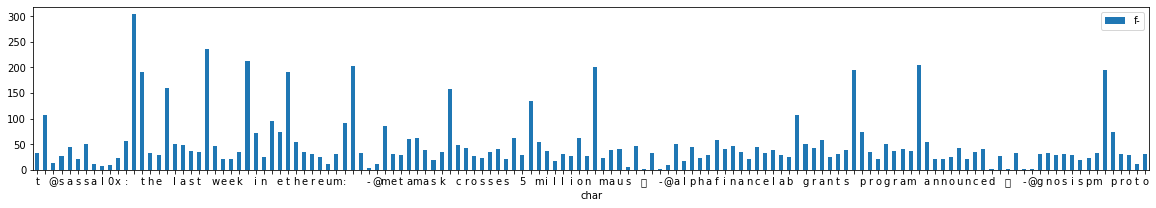

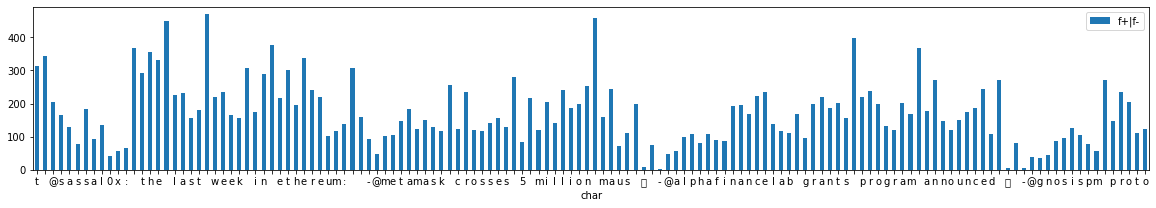

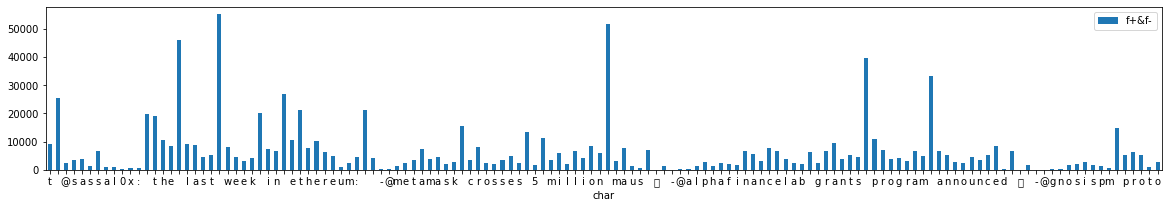

In [73]:
text = feeds_df.loc[0]['text'].lower()
df = plot_profile_freedoms(model,text,3,plot=True,debug=False)
df['f+|f-']=df['f+'] + df['f-']
df['f+&f-']=df['f+'] * df['f-']
plot_profile(df[['char','f+|f-']],text)
plot_profile(df[['char','f+&f-']],text)


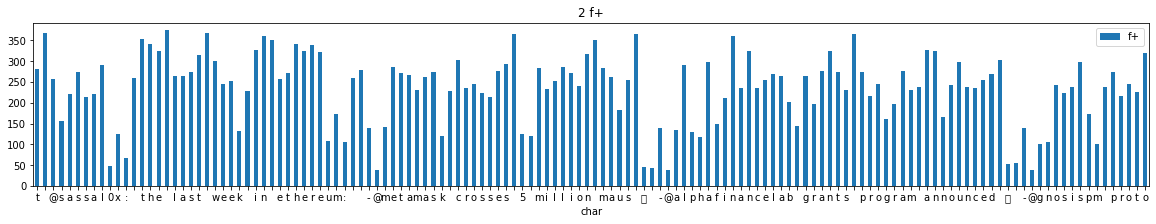

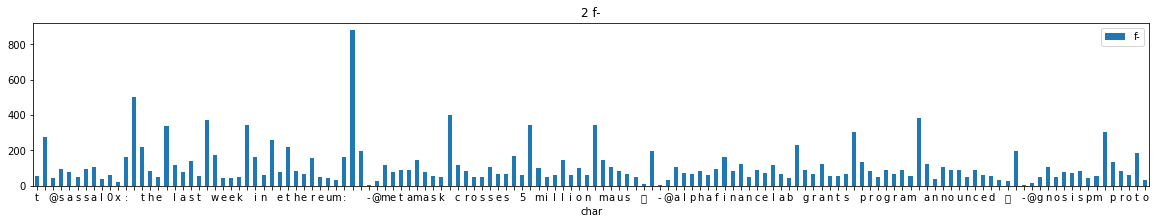

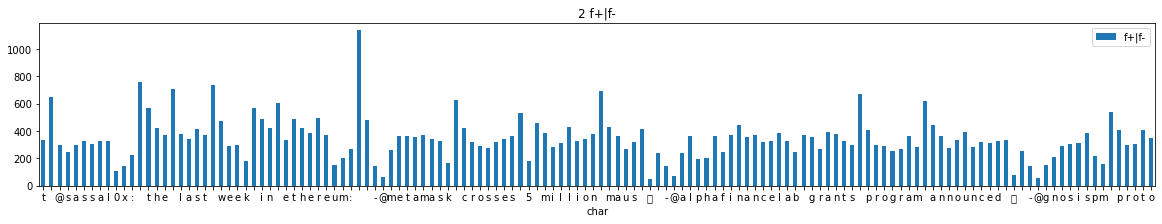

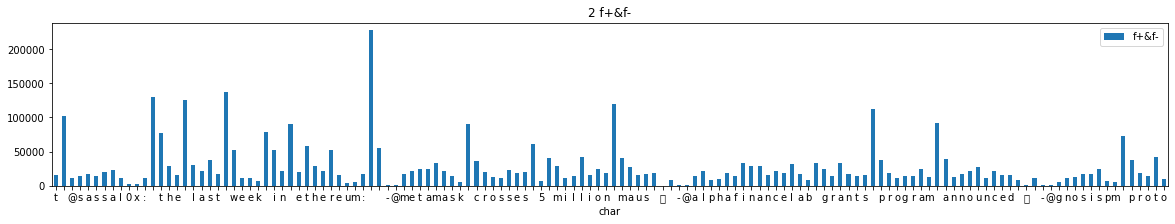

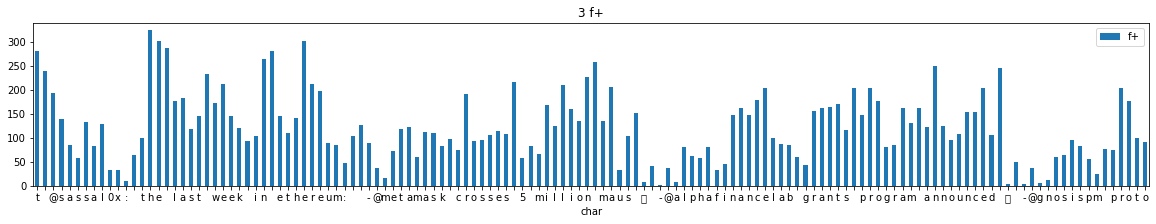

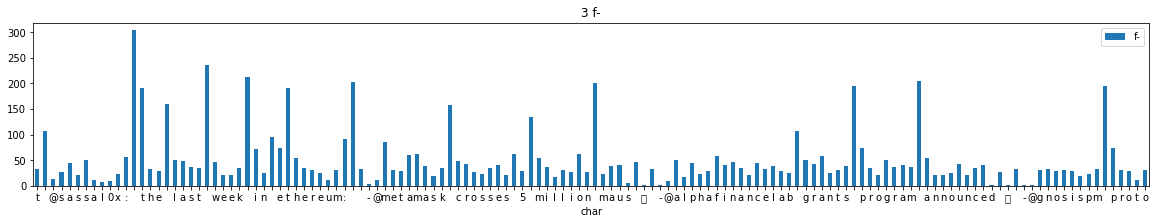

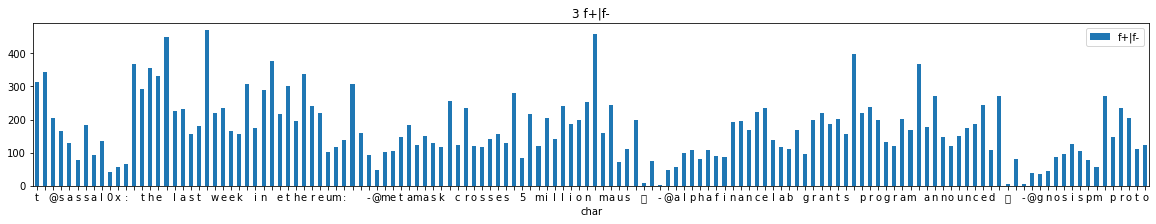

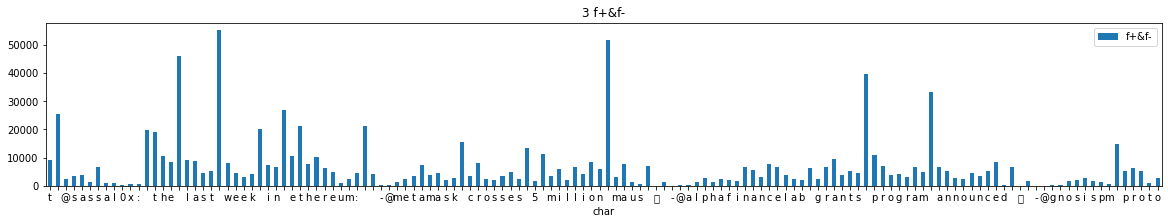

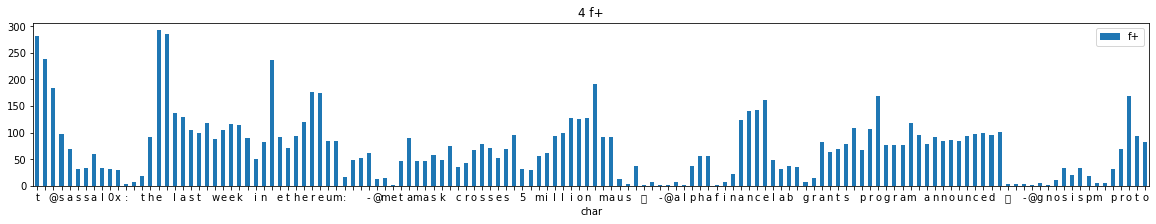

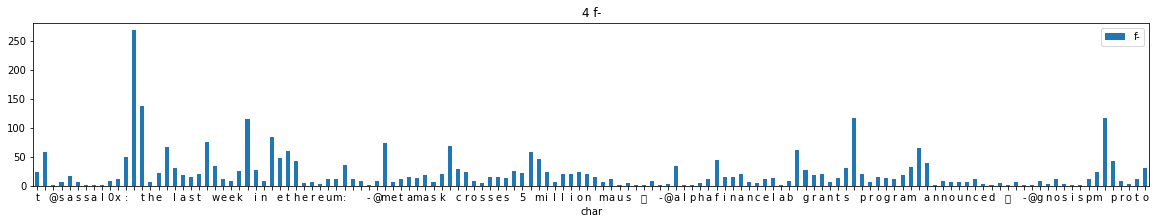

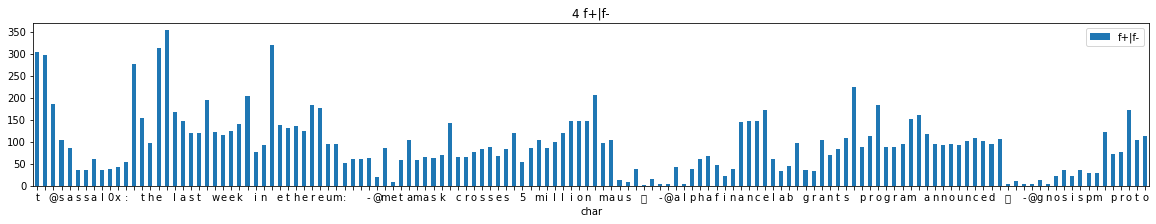

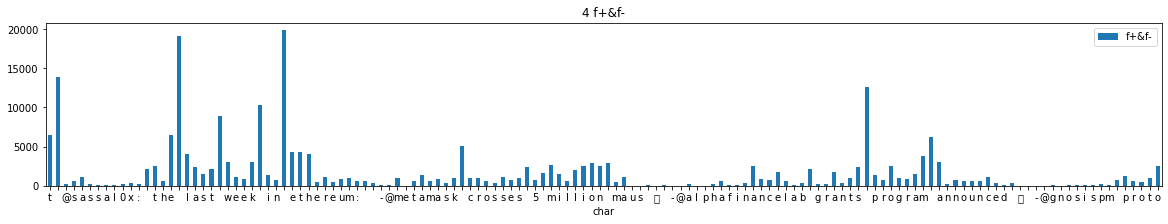

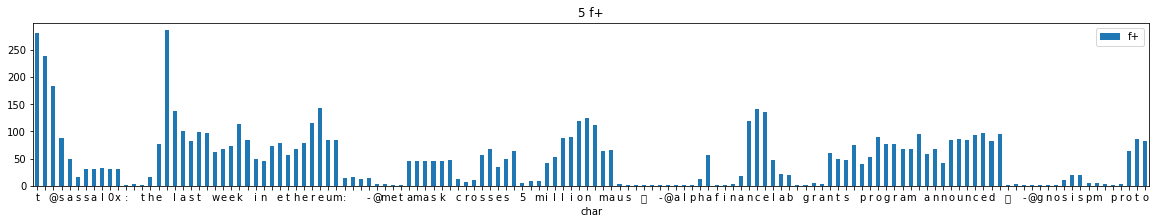

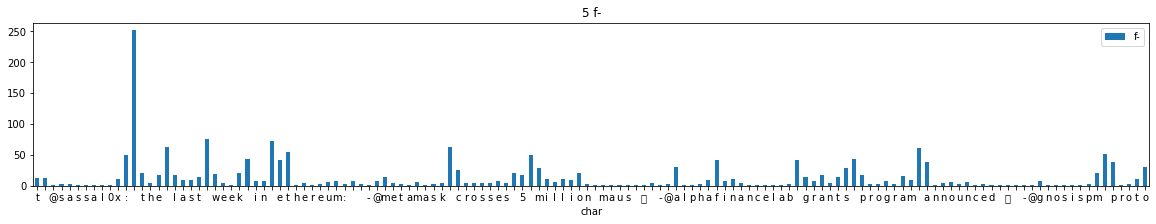

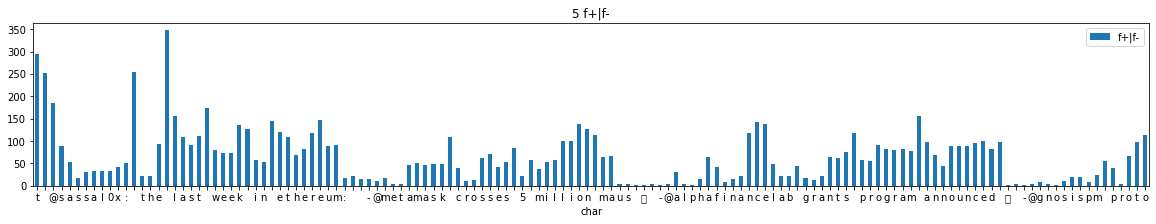

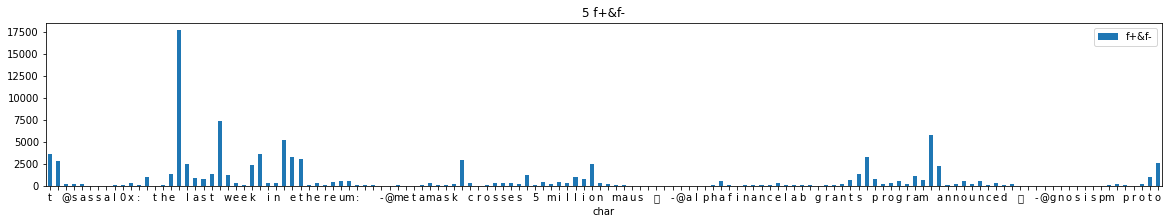

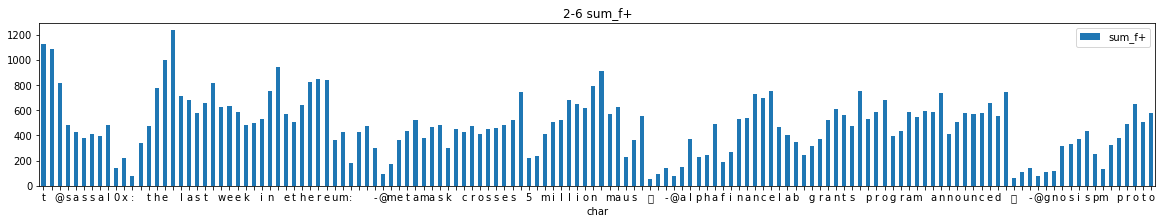

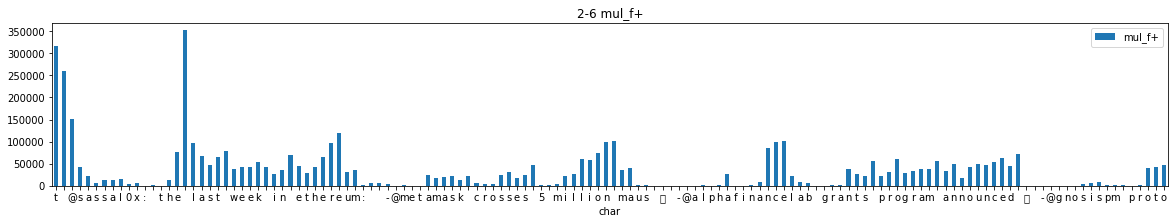

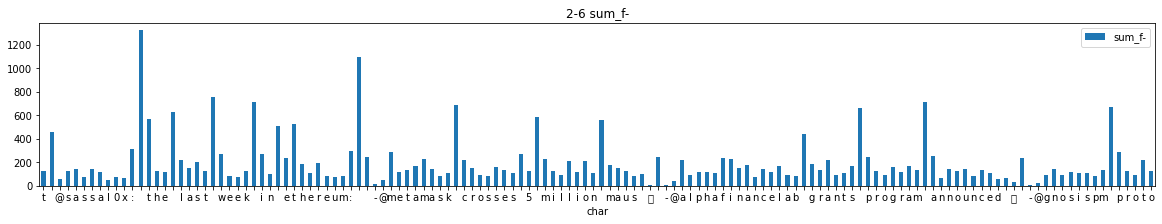

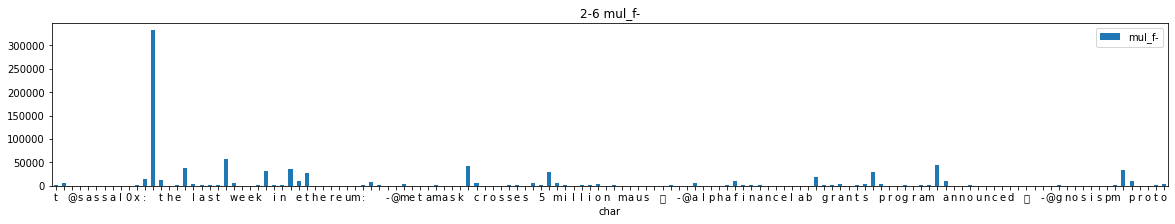

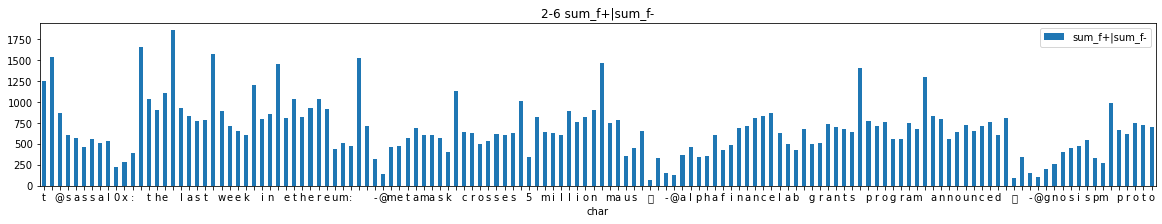

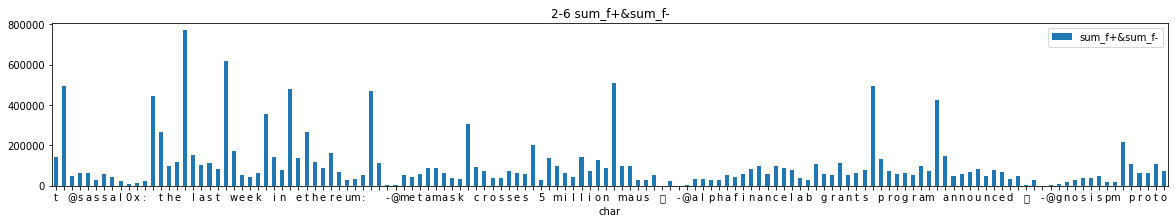

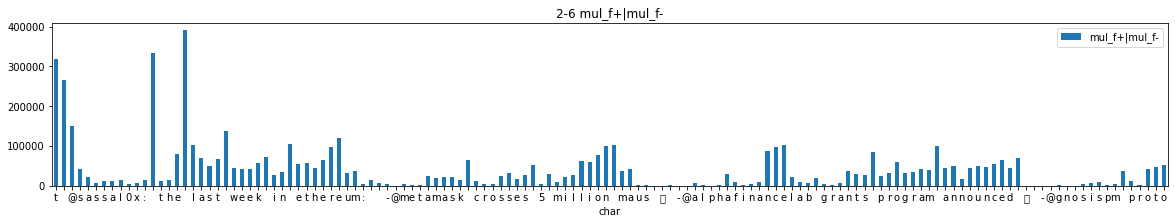

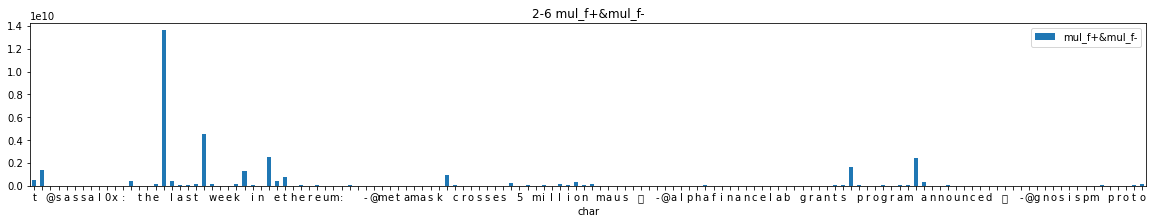

In [85]:
text = feeds_df.loc[0]['text'].lower()
sdf = None
for i in range(2,6):
    df = plot_profile_freedoms(model,text,i,False)
    df['f+|f-']=df['f+'] + df['f-']
    df['f+&f-']=df['f+'] * df['f-']
    plot_profile(df[['char','f+']],text,title=str(i)+' f+')
    plot_profile(df[['char','f-']],text,title=str(i)+' f-')
    plot_profile(df[['char','f+|f-']],text,title=str(i)+' f+|f-')
    plot_profile(df[['char','f+&f-']],text,title=str(i)+' f+&f-')
    if sdf is None:
        sdf = df
        sdf['sum_f+'] = df['f+']
        sdf['mul_f+'] = df['f+']
        sdf['sum_f-'] = df['f-']
        sdf['mul_f-'] = df['f-']
        sdf.drop('f+', inplace=True, axis=1)
        sdf.drop('f-', inplace=True, axis=1)
    else:
        sdf['sum_f+'] = sdf['sum_f+'] + df['f+']
        sdf['mul_f+'] = sdf['sum_f+'] * df['f+']
        sdf['sum_f-'] = sdf['sum_f-'] + df['f-']
        sdf['mul_f-'] = sdf['sum_f-'] * df['f-']

sdf['sum_f+|sum_f-'] = sdf['sum_f+'] + sdf['sum_f-']
sdf['sum_f+&sum_f-'] = sdf['sum_f+'] * sdf['sum_f-']
sdf['mul_f+|mul_f-'] = sdf['mul_f+'] + sdf['mul_f-']
sdf['mul_f+&mul_f-'] = sdf['mul_f+'] * sdf['mul_f-']

for c in ['sum_f+','mul_f+','sum_f-','mul_f-','sum_f+|sum_f-','sum_f+&sum_f-','mul_f+|mul_f-','mul_f+&mul_f-']:
    plot_profile(sdf[['char',c]],text,title='2-6 '+c)


In [ ]:
#TODO count tries!? https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2655800/

#TODO pre-train freq model for Tokenization on corpus, including A) words B) individual delimiters, C) generated numbers, D) generated dates

#TODO tokenize by clustering words in the sentence by gram counts - using MUTUAL INFORMATION!!!

#TODO how to split endings delimiters away from words!?

#TODO inhibit frequencies from higher-order to lower-order?

#TODO decapitalization?

#TODO decode '\u200b'


